# Purwapedia: Preventing Customer Churn with Machine Learning Prediction

# 1. Business Problem Statement

Purwapedia is your smart & rewarding shopping companion. We offer curated products, fast PurwaExpress delivery, and a loyalty program (PurwaPoints) to make online shopping seamless and satisfying. Last month, we noticed a worrying trend. Out of 5,630 users, 16% (≈900 customers) stopped engaging with us. They are "churning", means leaving our platform for competitors. This is a signal that parts of our customer experience are failing.

The Kaggle dataset represents a **general e-commerce retail model**, where churn means customers became inactive. For this project, we **assume the dataset reflects one month of customer activity**. Under this assumption, the ~16% churn rate is far above healthy monthly benchmarks of **5–10%** seen in subscription-style e-commerce ([ScaleMath](https://scalemath.com/blog/what-is-a-good-monthly-churn-rate/?utm_source=chatgpt.com); [Opensend](https://www.opensend.com/post/churn-rate-ecommerce?utm_source=chatgpt.com)).  
This makes churn reduction a **serious business problem** and a strong candidate for predictive modeling and retention strategies.

## 1.1. Evaluation Metrics

For this churn dataset, the following evaluation setup will be used:

1. **Main Metric → F2-Score**  
   - Prioritizes Recall 4× more than Precision, reflecting the fact that **acquiring a new customer is 5–25× more expensive than retaining an existing one** ([Harvard Business Review, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers?utm_source=chatgpt.com)).  
   - This makes missing churners (false negatives) far more costly than mistakenly targeting loyal customers (false positives).  
   - Supported by churn prediction literature, where Recall-oriented metrics (e.g., F2) are recommended for imbalanced datasets ([Verbeke et al., 2012](https://doi.org/10.1016/j.dss.2012.05.005)).  

2. **Supporting Metric → ROC-AUC**  
   - Evaluates model discriminative power independent of thresholds.  
   - Widely used in churn research as a benchmark for classification quality. 

**Summary:**  
- **F2-Score** will be the headline evaluation metric.  
- **ROC-AUC** provides a threshold-independent comparison across models.

# 2. Data Understanding

In [63]:
import warnings
warnings.filterwarnings(action='ignore')

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the datasets
file_path = 'E Commerce Dataset.xlsx'
df_ecommerce = pd.read_excel(file_path, sheet_name='E Comm')
df_dict = pd.read_excel(file_path, sheet_name='Data Dict')

print("Feature Descriptions:")
display(df_dict)

print("\nE-commerce Data Head:")
display(df_ecommerce.head())

Feature Descriptions:


Unnamed: 0 Unnamed: 1                   Unnamed: 2  \
0          NaN       Data                     Variable   
1          NaN     E Comm                   CustomerID   
2          NaN     E Comm                        Churn   
3          NaN     E Comm                       Tenure   
4          NaN     E Comm         PreferredLoginDevice   
5          NaN     E Comm                     CityTier   
6          NaN     E Comm              WarehouseToHome   
7          NaN     E Comm         PreferredPaymentMode   
8          NaN     E Comm                       Gender   
9          NaN     E Comm               HourSpendOnApp   
10         NaN     E Comm     NumberOfDeviceRegistered   
11         NaN     E Comm             PreferedOrderCat   
12         NaN     E Comm            SatisfactionScore   
13         NaN     E Comm                MaritalStatus   
14         NaN     E Comm              NumberOfAddress   
15         NaN     E Comm                     Complain   
16         NaN     E Comm  OrderAmountHikeFromlastYear   
17         NaN     E Comm                   CouponUsed   
18         NaN     E Comm                   OrderCount   
19         NaN     E Comm            DaySinceLastOrder   
20         NaN     E Comm               CashbackAmount   

                                           Unnamed: 3  
0                                         Discerption  
1                                  Unique customer ID  
2                                          Churn Flag  
3                  Tenure of customer in organization  
4                  Preferred login device of customer  
5                                           City tier  
6   Distance in between warehouse to home of customer  
7                Preferred payment method of customer  
8                                  Gender of customer  
9   Number of hours spend on mobile application or...  
10  Total number of deceives is registered on part...  
11  Preferred order category of customer in last m...  
12          Satisfactory score of customer on service  
13                         Marital status of customer  
14  Total number of added added on particular cust...  
15        Any complaint has been raised in last month  
16       Percentage increases in order from last year  
17  Total number of coupon has been used in last m...  
18  Total number of orders has been places in last...  
19                   Day Since last order by customer  
20                     Average cashback in last month


E-commerce Data Head:


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

In [65]:
# Check data types and look for missing values
print("Data Info:")
df_ecommerce.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

## 2. Initial Reconnaissance

### 2.1. `CustomerID` as Index

In [66]:
df_ecommerce.set_index('CustomerID', inplace=True)

### 2.2. Data Types Correction

In [67]:
# Discrete numbers
df_ecommerce = df_ecommerce.astype({
    "Churn": "Int8",
    "Tenure": "Int64",
    "CityTier": "Int8",
    "NumberOfDeviceRegistered": "Int8",
    "SatisfactionScore": "Int8",
    "NumberOfAddress": "Int8",
    "Complain": "Int8", # 0 (No) and 1 (Yes) only (categorical) -> keep as Int8 for skipping conversion to bool
    "CouponUsed": "Int64",
    "OrderCount": "Int64",
    "DaySinceLastOrder": "Int64",
})

# Convert categoricals
categorical_cols = [
    "PreferredLoginDevice", "PreferredPaymentMode",
    "Gender", "PreferedOrderCat", "MaritalStatus"
]
# df_ecommerce[categorical_cols] = df_ecommerce[categorical_cols].astype("category")
df_ecommerce.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 50001 to 55630
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   Int8   
 1   Tenure                       5366 non-null   Int64  
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   Int8   
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   Int8   
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   Int8   
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   Int8   
 13  Complain          

In [68]:
df_ecommerce.head()

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
CustomerID                                                                  
50001           1       4         Mobile Phone         3              6.0   
50002           1    <NA>                Phone         1              8.0   
50003           1    <NA>                Phone         1             30.0   
50004           1       0                Phone         3             15.0   
50005           1       0                Phone         1             12.0   

           PreferredPaymentMode  Gender  HourSpendOnApp  \
CustomerID                                                
50001                Debit Card  Female             3.0   
50002                       UPI    Male             3.0   
50003                Debit Card    Male             2.0   
50004                Debit Card    Male             2.0   
50005                        CC    Male             NaN   

            NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
CustomerID                                                                    
50001                              3  Laptop & Accessory                  2   
50002                              4              Mobile                  3   
50003                              4              Mobile                  3   
50004                              4  Laptop & Accessory                  5   
50005                              3              Mobile                  5   

           MaritalStatus  NumberOfAddress  Complain  \
CustomerID                                            
50001             Single                9         1   
50002             Single                7         1   
50003             Single                6         1   
50004             Single                8         0   
50005             Single                3         0   

            OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
CustomerID                                                        
50001                              11.0           1           1   
50002                              15.0           0           1   
50003                              14.0           0           1   
50004                              23.0           0           1   
50005                              11.0           1           1   

            DaySinceLastOrder  CashbackAmount  
CustomerID                                     
50001                       5          159.93  
50002                       0          120.90  
50003                       3          120.28  
50004                       3          134.07  
50005                       3          129.60

Missing Values Exist

# 3. Exploratory Data Analysis (EDA) on Customer Churn

## 3.3. Descriptive Dive

In [69]:
# Calculate key statistics
print("Descriptive Statistics:")
display(df_ecommerce.describe())

Descriptive Statistics:


Churn     Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
count    5630.0     5366.0    5630.0      5379.000000     5375.000000   
mean   0.168384  10.189899  1.654707        15.639896        2.931535   
std     0.37424   8.557241  0.915389         8.531475        0.721926   
min         0.0        0.0       1.0         5.000000        0.000000   
25%         0.0        2.0       1.0         9.000000        2.000000   
50%         0.0        9.0       1.0        14.000000        3.000000   
75%         0.0       16.0       3.0        20.000000        3.000000   
max         1.0       61.0       3.0       127.000000        5.000000   

       NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
count                    5630.0             5630.0           5630.0    5630.0   
mean                   3.688988           3.066785         4.214032  0.284902   
std                    1.023999           1.380194         2.583586  0.451408   
min                         1.0                1.0              1.0       0.0   
25%                         3.0                2.0              2.0       0.0   
50%                         4.0                3.0              3.0       0.0   
75%                         4.0                4.0              6.0       1.0   
max                         6.0                5.0             22.0       1.0   

       OrderAmountHikeFromlastYear  CouponUsed  OrderCount  DaySinceLastOrder  \
count                  5365.000000      5374.0      5372.0             5323.0   
mean                     15.707922    1.751023    3.008004           4.543491   
std                       3.675485    1.894621     2.93968           3.654433   
min                      11.000000         0.0         1.0                0.0   
25%                      13.000000         1.0         1.0                2.0   
50%                      15.000000         1.0         2.0                3.0   
75%                      18.000000         2.0         3.0                7.0   
max                      26.000000        16.0        16.0               46.0   

       CashbackAmount  
count     5630.000000  
mean       177.223030  
std         49.207036  
min          0.000000  
25%        145.770000  
50%        163.280000  
75%        196.392500  
max        324.990000

## 3.4. Inconsistency Handling

In [70]:
print("Pre-Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())
print(50 * "-")

# Standardize payment mode values
df_ecommerce['PreferredPaymentMode'] = df_ecommerce['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})

# Standardize login device
df_ecommerce['PreferredLoginDevice'] = df_ecommerce['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

# Standardize order category
df_ecommerce['PreferedOrderCat'] = df_ecommerce['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

print("Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())

Pre-Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Unique Login Devices: ['Mobile Phone' 'Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
--------------------------------------------------
Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique Login Devices: ['Mobile Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']


## 3.5. In-Depth Numerical Analysis

### 3.5.1. Univariate Numerical Analysis

In [71]:
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

def analyze_numerical_feature(df, col):
    """
    Analyze a numerical feature with distribution, Q-Q plot, boxplot, 
    and Shapiro-Wilk normality test.
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of the numerical feature
    """
    print(f'{"="*20} Analyzing Numerical Feature: {col} {"="*20}\n')
    
    # Distribution, Normality, and Outlier Check
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    
    # Q-Q Plot
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'Q-Q Plot of {col}')
    
    # Boxplot for Outliers
    sns.boxplot(y=df[col], ax=axes[2])
    axes[2].set_title(f'Boxplot of {col} (Outliers)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Numerical Feature: Tenure ====================



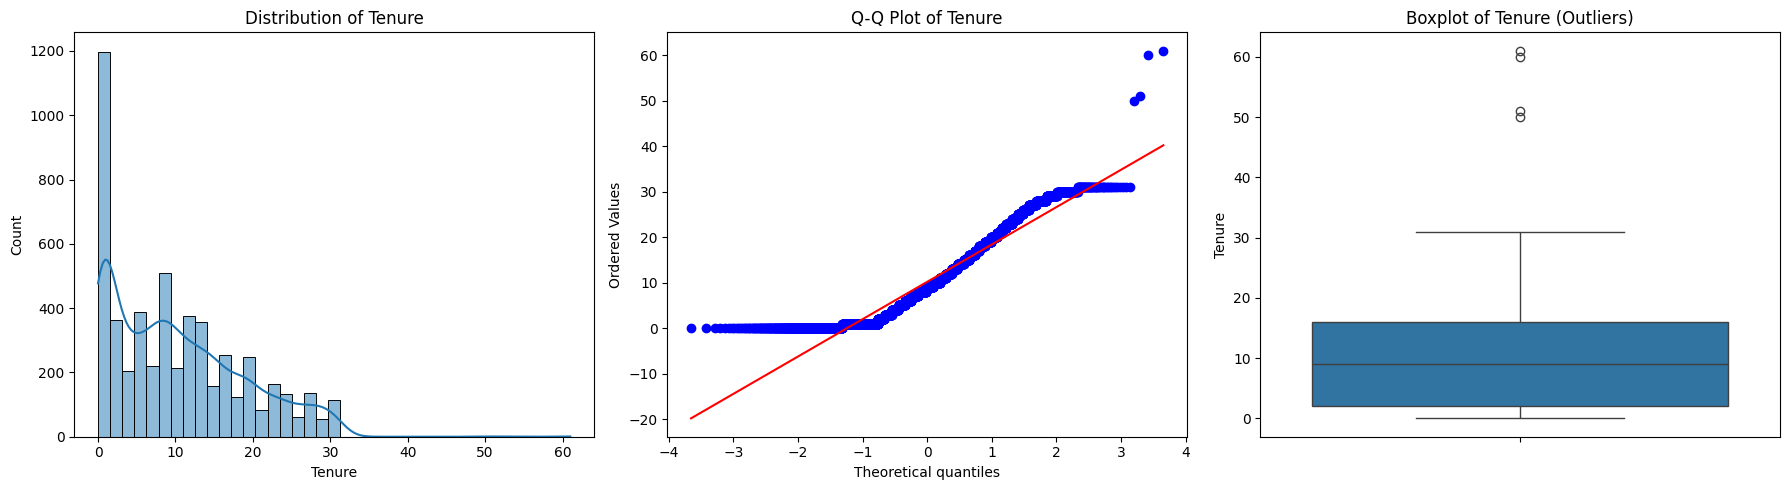

In [72]:
analyze_numerical_feature(df_ecommerce, 'Tenure')


The distribution of customer tenure is **right-skewed**, meaning most customers have a short tenure. The Q-Q plot shows a clear departure from the theoretical quantiles, confirming the non-normal distribution. The boxplot highlights several outliers, representing customers with a very long tenure.

#### WarehouseToHome

==================== Analyzing Numerical Feature: WarehouseToHome ====================



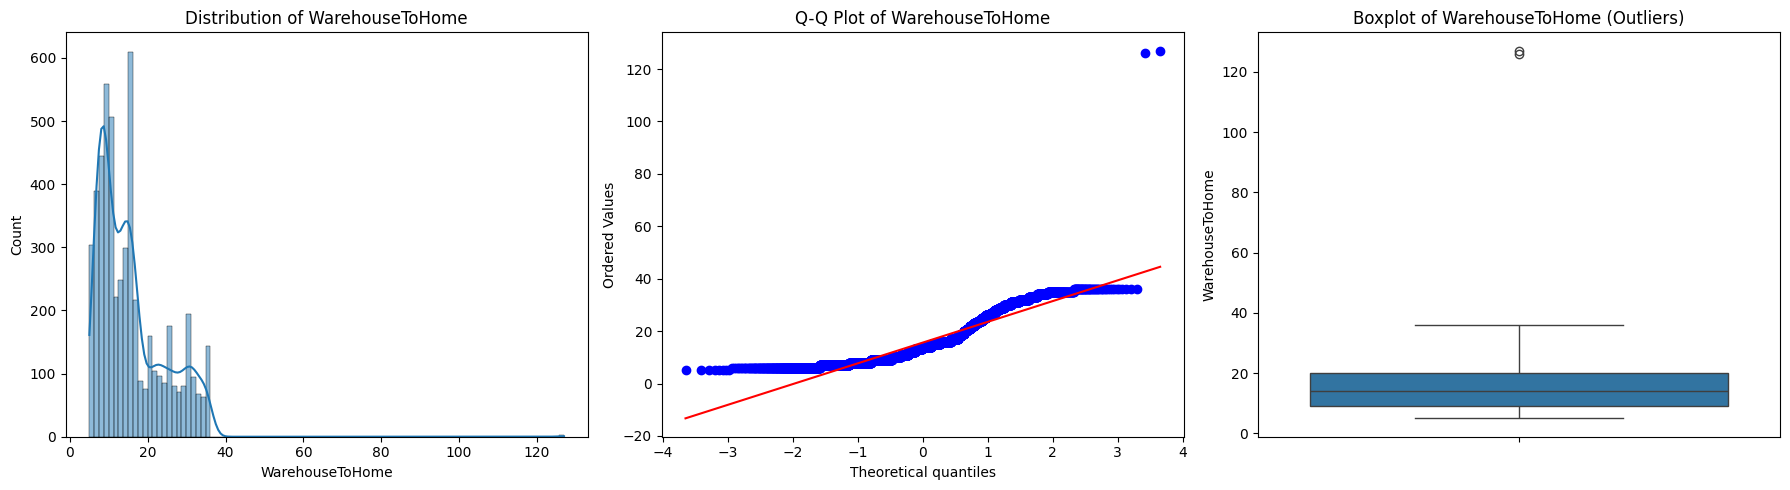

In [73]:
analyze_numerical_feature(df_ecommerce, 'WarehouseToHome')

This distribution is also **right-skewed**, with most customers living relatively close to the warehouse (less than 20 units of distance). The Q-Q plot indicates a non-normal distribution, with the points deviating significantly from the red line. The boxplot shows many outliers, representing customers who live a great distance from the warehouse.


#### HourSpendOnApp

==================== Analyzing Numerical Feature: HourSpendOnApp ====================



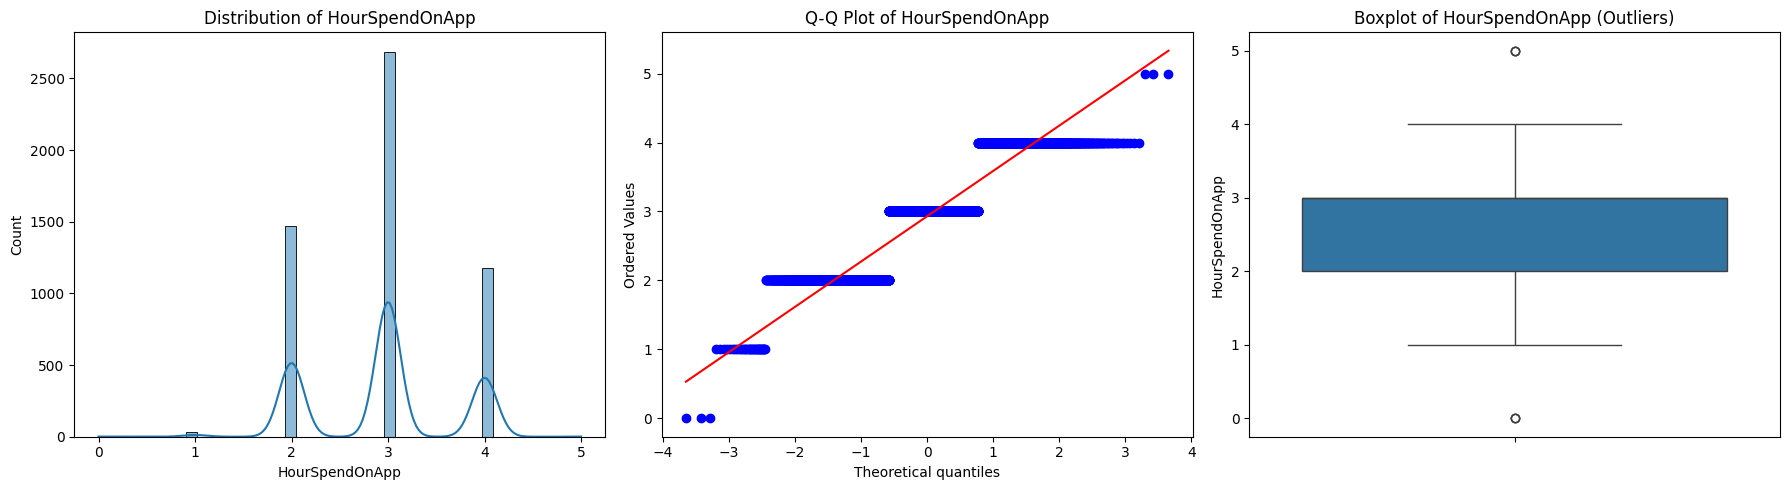

In [74]:
analyze_numerical_feature(df_ecommerce, 'HourSpendOnApp')

The distribution is **multimodal**, with clear peaks at 1, 2, 3, and 4 hours. The most common time spent on the app is 3 hours. The Q-Q plot shows that the data is not normally distributed. The boxplot shows outliers at 0 and 5 hours.

#### NumberOfDeviceRegistered

==================== Analyzing Numerical Feature: NumberOfDeviceRegistered ====================



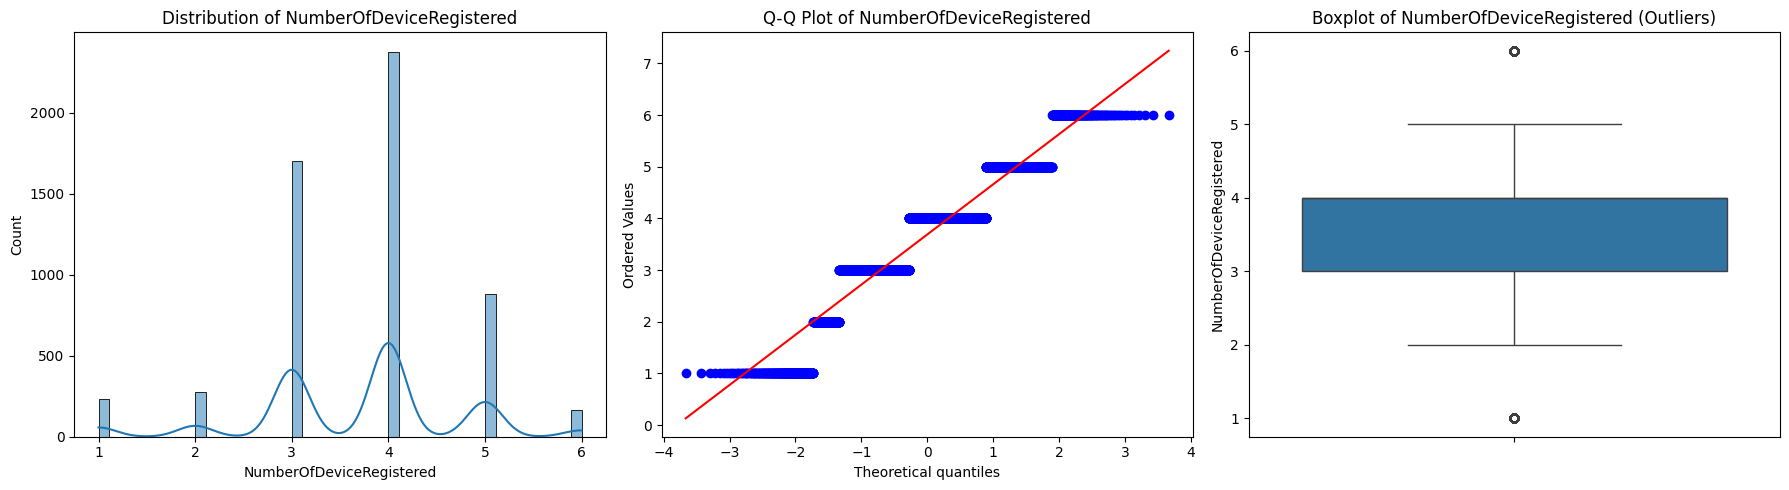

In [75]:
analyze_numerical_feature(df_ecommerce, 'NumberOfDeviceRegistered')

The distribution is **multimodal**, with distinct peaks at 1, 3, 4, 5, and 6 devices. The most common number of devices is 4. The data is not normally distributed, as shown by the Q-Q plot and the distinct peaks in the histogram. The boxplot indicates a few outliers, with a registered device count of 1 and 6.

#### NumberOfAddress

==================== Analyzing Numerical Feature: NumberOfAddress ====================



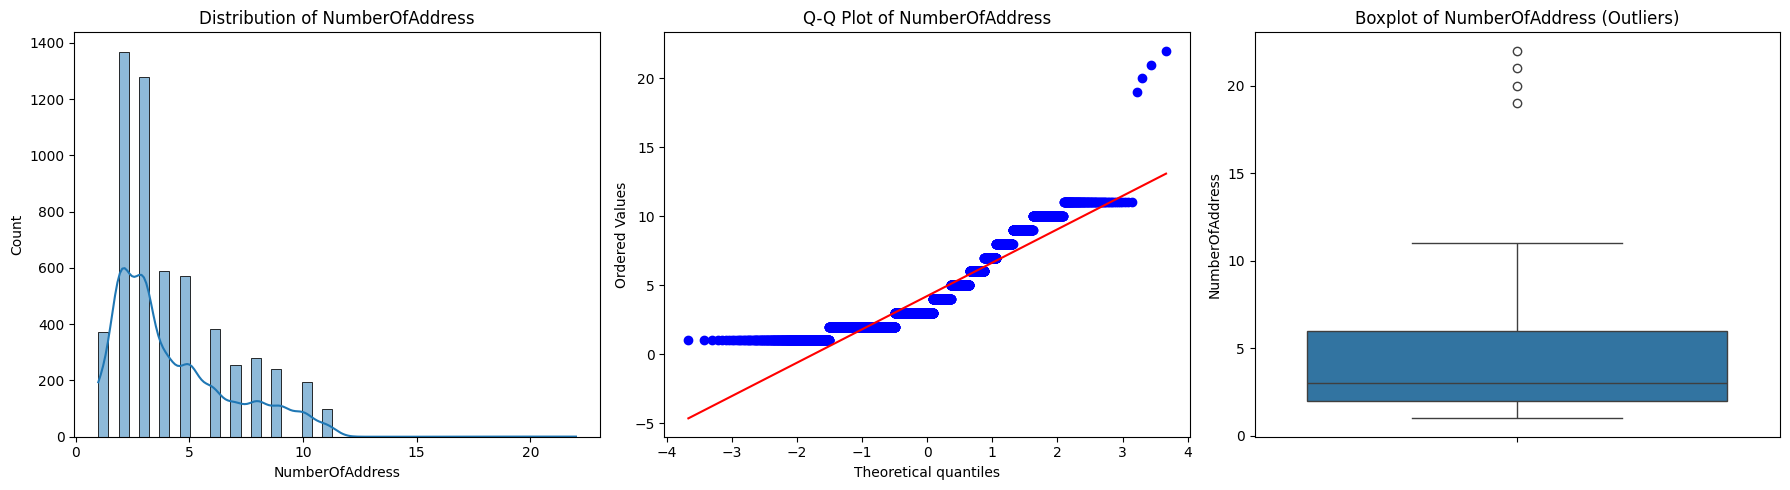

In [76]:
analyze_numerical_feature(df_ecommerce, 'NumberOfAddress')

The data is **heavily right-skewed**, with most customers having a small number of addresses (1 to 5). The frequency of customers decreases significantly as the number of addresses increases. The Q-Q plot and the boxplot with multiple outliers confirm the non-normal and skewed nature of the data.

#### OrderAmountHikeFromlastYear

==================== Analyzing Numerical Feature: OrderAmountHikeFromlastYear ====================



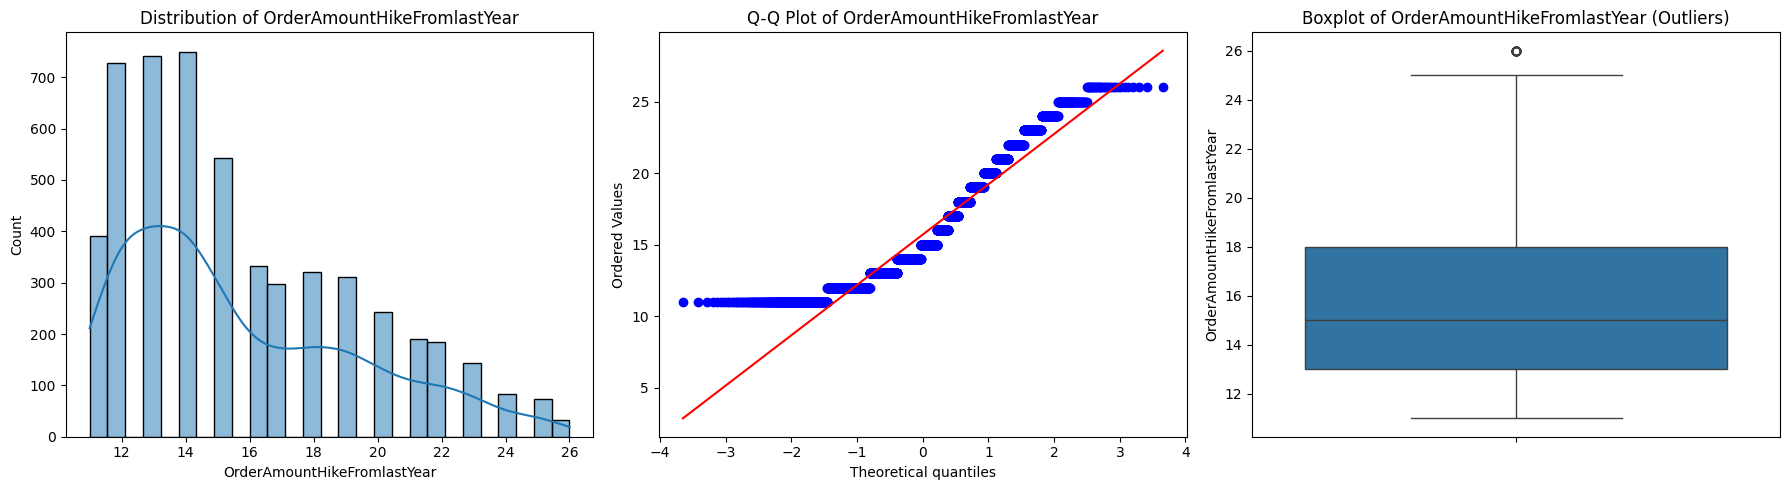

In [77]:
analyze_numerical_feature(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distribution appears **slightly left-skewed**, with a peak around a 14% to 15% increase. The Q-Q plot shows a slight deviation from the normal distribution. The boxplot reveals a few outliers at the upper and lower ends of the range.

#### CouponUsed

==================== Analyzing Numerical Feature: CouponUsed ====================



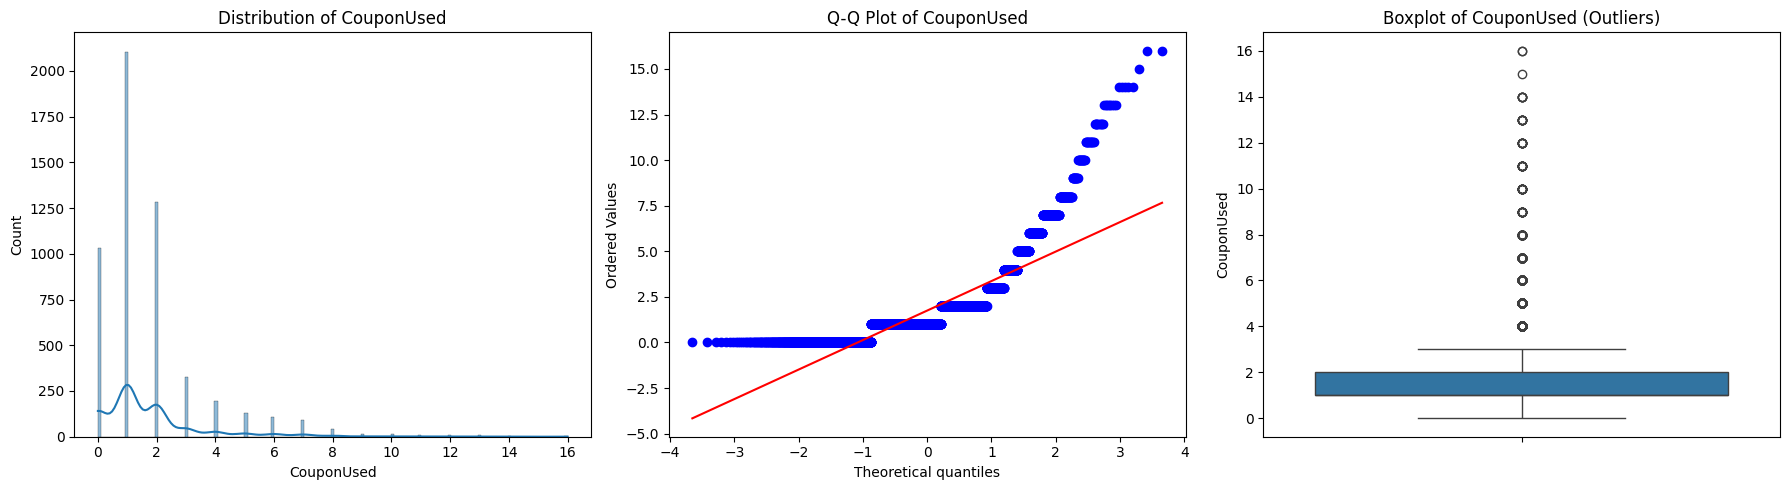

In [78]:
analyze_numerical_feature(df_ecommerce, 'CouponUsed')

The distribution of coupons used is **heavily right-skewed**, with a large majority of customers using 0 or 1 coupon. The number of customers drops dramatically as the number of coupons used increases. The Q-Q plot and the boxplot with many outliers confirm this extreme skewness.

#### OrderCount

==================== Analyzing Numerical Feature: OrderCount ====================



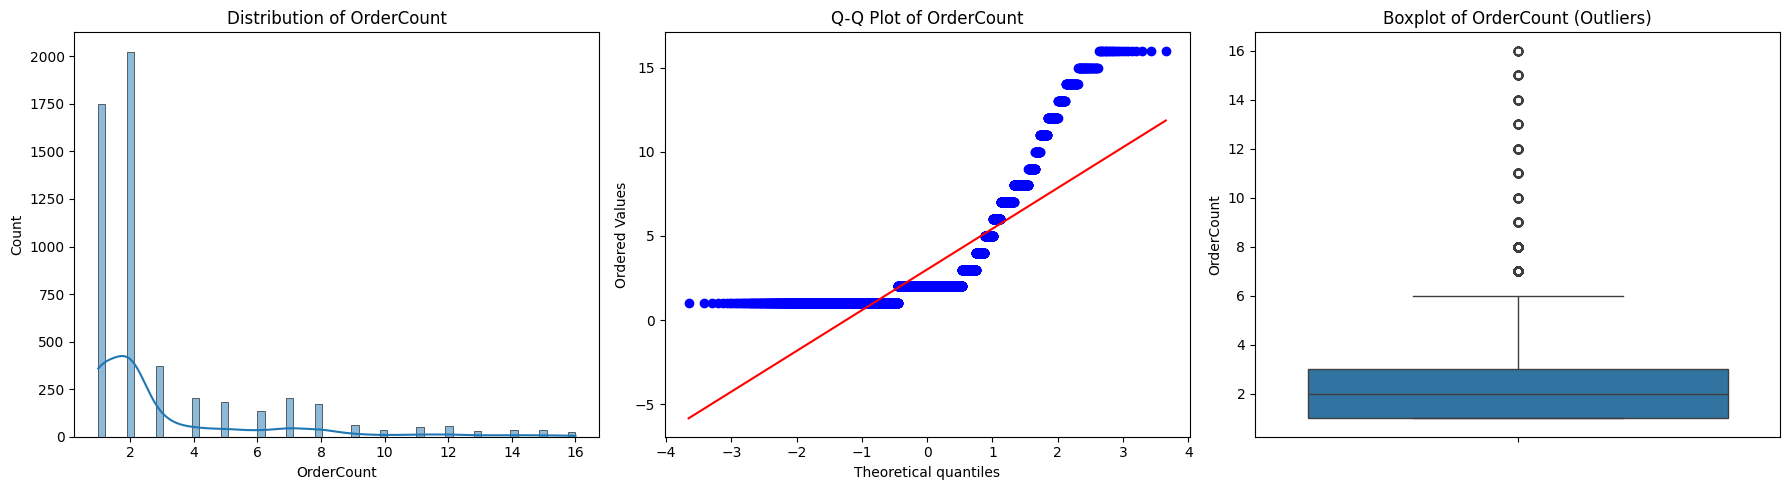

In [79]:
analyze_numerical_feature(df_ecommerce, 'OrderCount')

The data for order count is **heavily right-skewed**, with most customers having a low number of orders (1 or 2). As the order count increases, the frequency of customers drops sharply. The Q-Q plot and the boxplot with numerous outliers confirm this pattern.

#### DaySinceLastOrder

==================== Analyzing Numerical Feature: DaySinceLastOrder ====================



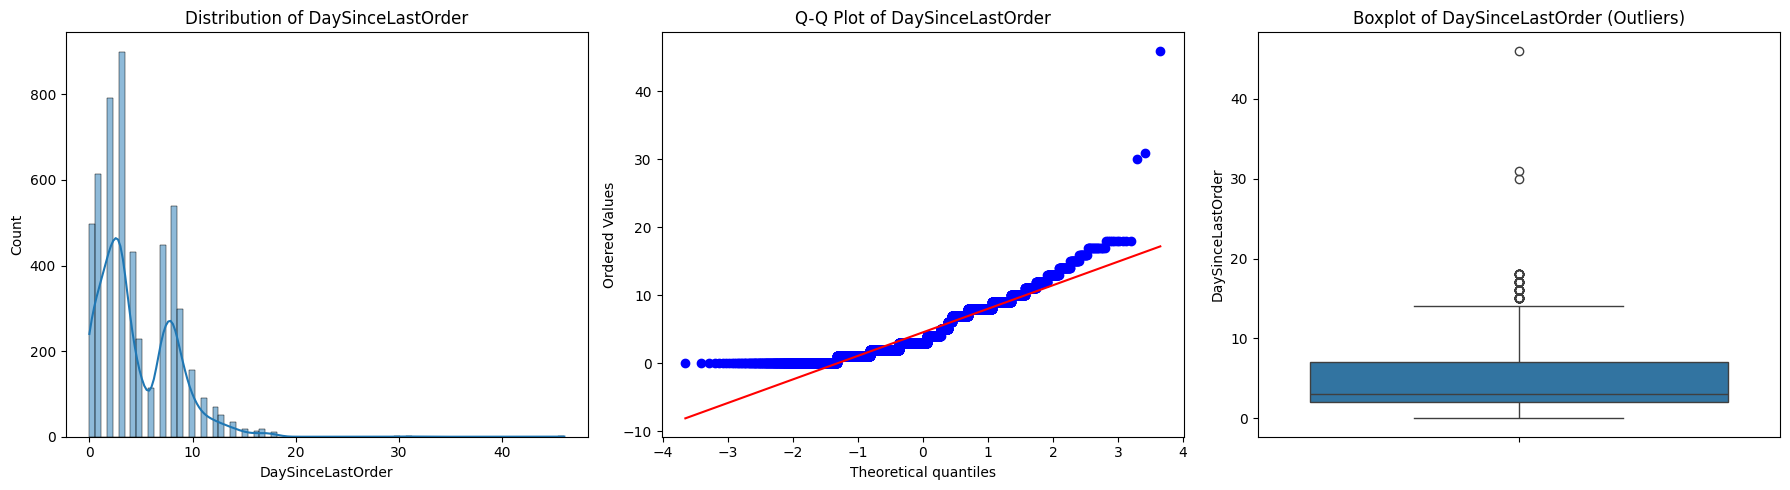

In [80]:
analyze_numerical_feature(df_ecommerce, 'DaySinceLastOrder')

The data is heavily **right-skewed**, indicating that most customers placed an order very recently. The majority of customers last ordered within the first 10 days. The Q-Q plot shows a clear departure from the normal distribution, confirming the skewness. The boxplot reveals numerous outliers, representing customers who haven't ordered in a long time.

#### CashbackAmount

==================== Analyzing Numerical Feature: CashbackAmount ====================



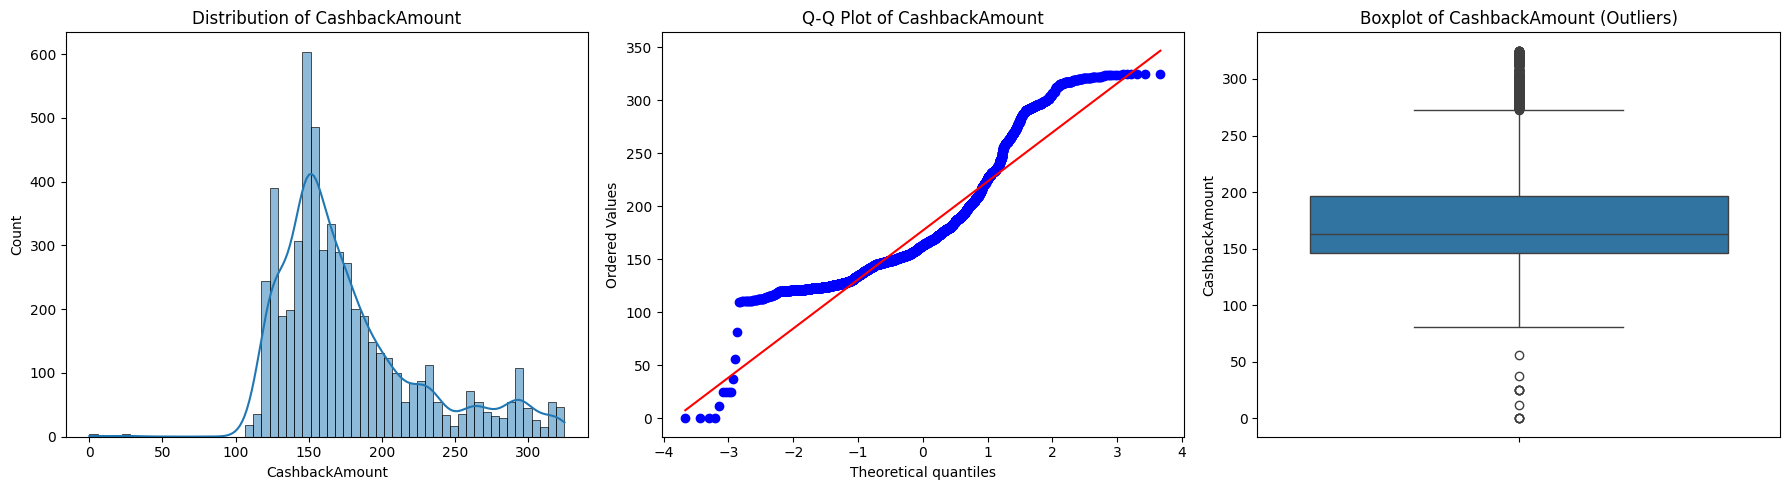

In [81]:
analyze_numerical_feature(df_ecommerce, 'CashbackAmount')

The distribution of cashback amount is **bimodal**, with two peaks. This suggests that there might be two different groups of customers based on their cashback amount. The Q-Q plot confirms that the data is not normally distributed. The boxplot shows several outliers on both the high and low ends.

### 3.5.2. Bivariate Numerical Analysis

In [82]:
def analyze_numerical_by_churn(df, col, target='Churn'):
    """
    Analyze a numerical feature with respect to a binary target (Churn).
    Includes boxplot, histogram with KDE, and appropriate statistical test
    (T-test if normal, Mann-Whitney U if not).
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of numerical feature
    - target: target column name (default 'Churn')
    """
    print(f'{"="*20} Analyzing {col} by {target} {"="*20}\n')
    
    plt.figure(figsize=(14, 6))  # Adjust figure size for two plots
    
    # Boxplot by Churn with distinct colors
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=col, data=df, hue=target, palette='viridis', legend=False)
    plt.title(f'Boxplot of {col} by {target}')
    
    # Histplot with KDE by Churn
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=col, hue=target, kde=True, palette='viridis', multiple="stack")
    plt.title(f'Distribution of {col} by {target} (KDE)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Tenure by Churn ====================



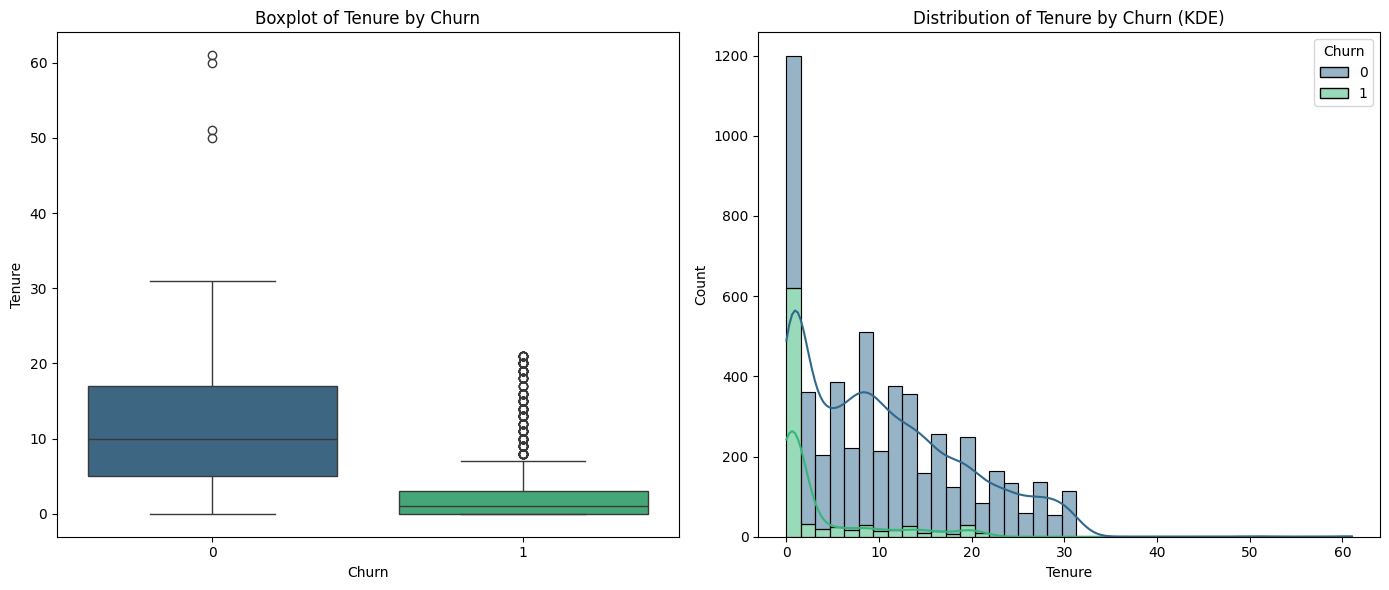

In [83]:
analyze_numerical_by_churn(df_ecommerce, 'Tenure')

There is a **strong relationship** between tenure and churn. The charts show that customers with **short tenure** (less than 5 units) are far more likely to churn than those with longer tenure. The median tenure for non-churning customers is significantly higher than for churning customers.

#### WarehouseToHome

==================== Analyzing WarehouseToHome by Churn ====================



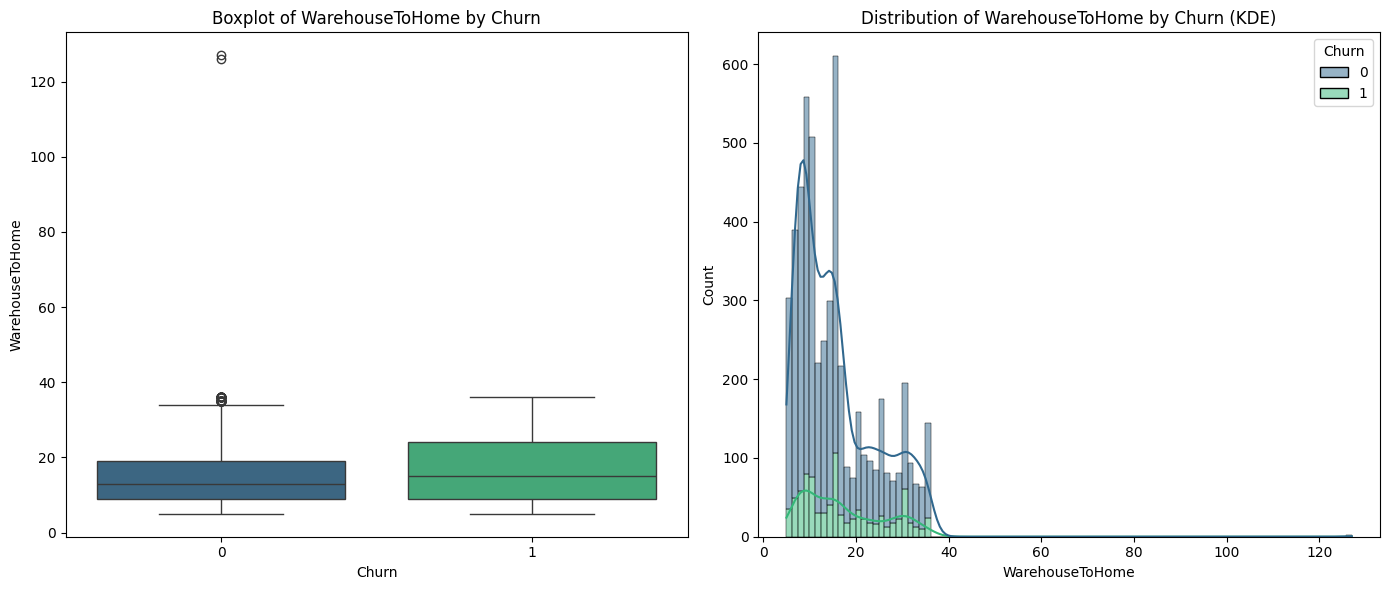

In [84]:
analyze_numerical_by_churn(df_ecommerce, 'WarehouseToHome')

There isn't a significant difference in the distribution of warehouse-to-home distance between churning and non-churning customers. The medians and overall boxplot ranges are very similar, suggesting this factor may not be a strong predictor of churn.

#### HourSpendOnApp

==================== Analyzing HourSpendOnApp by Churn ====================



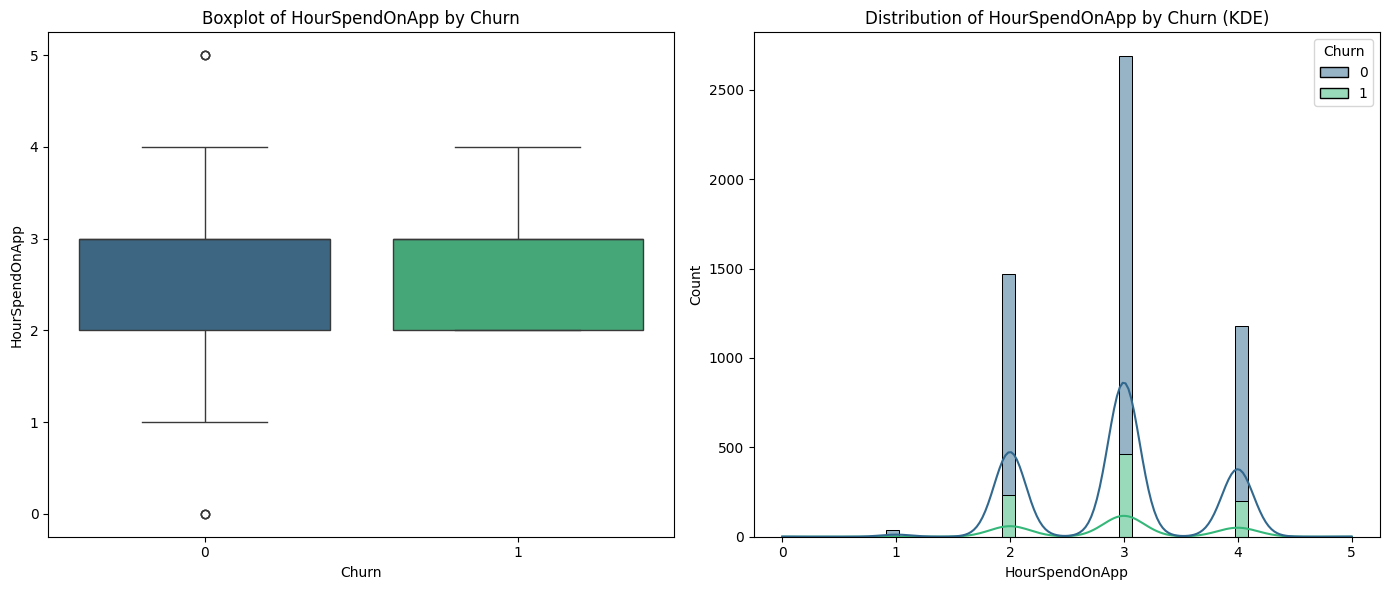

In [85]:
analyze_numerical_by_churn(df_ecommerce, 'HourSpendOnApp')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### NumberOfDeviceRegistered

==================== Analyzing NumberOfDeviceRegistered by Churn ====================



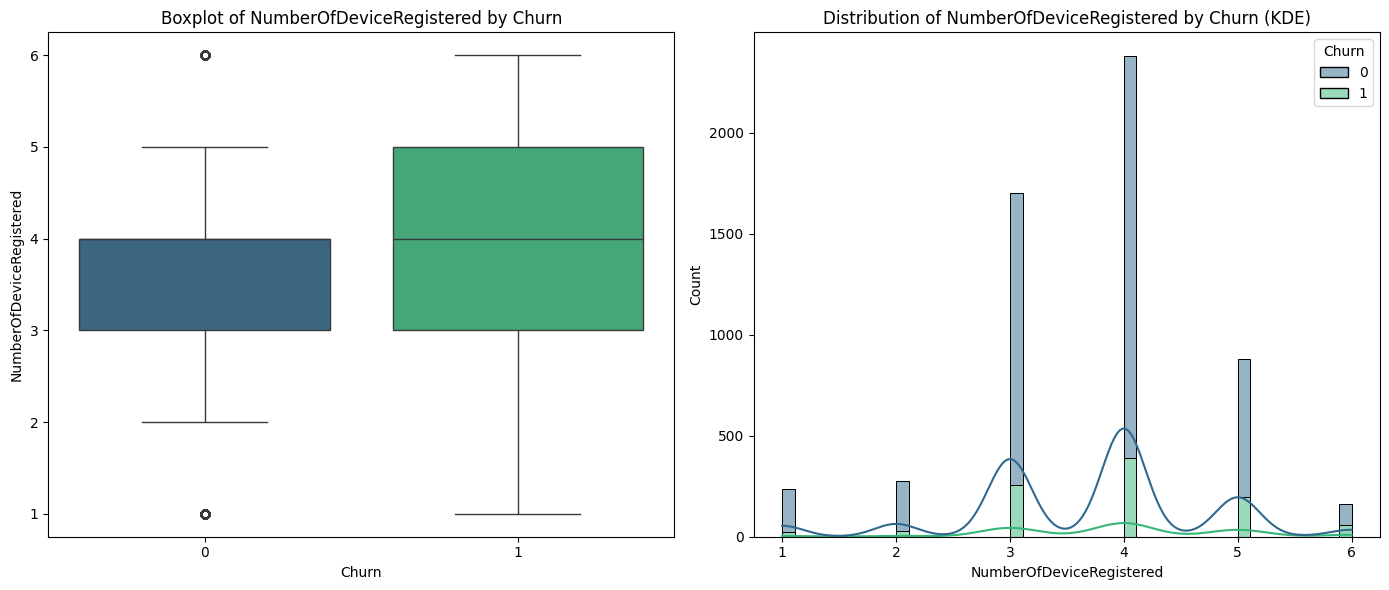

In [86]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfDeviceRegistered')

Customers who churn tend to have a **higher number of registered devices**. The median number of devices for churning customers is 4, while for non-churning customers it is 3. This could imply that customers with more registered devices are less committed to a single platform.

#### NumberOfAddress

==================== Analyzing NumberOfAddress by Churn ====================



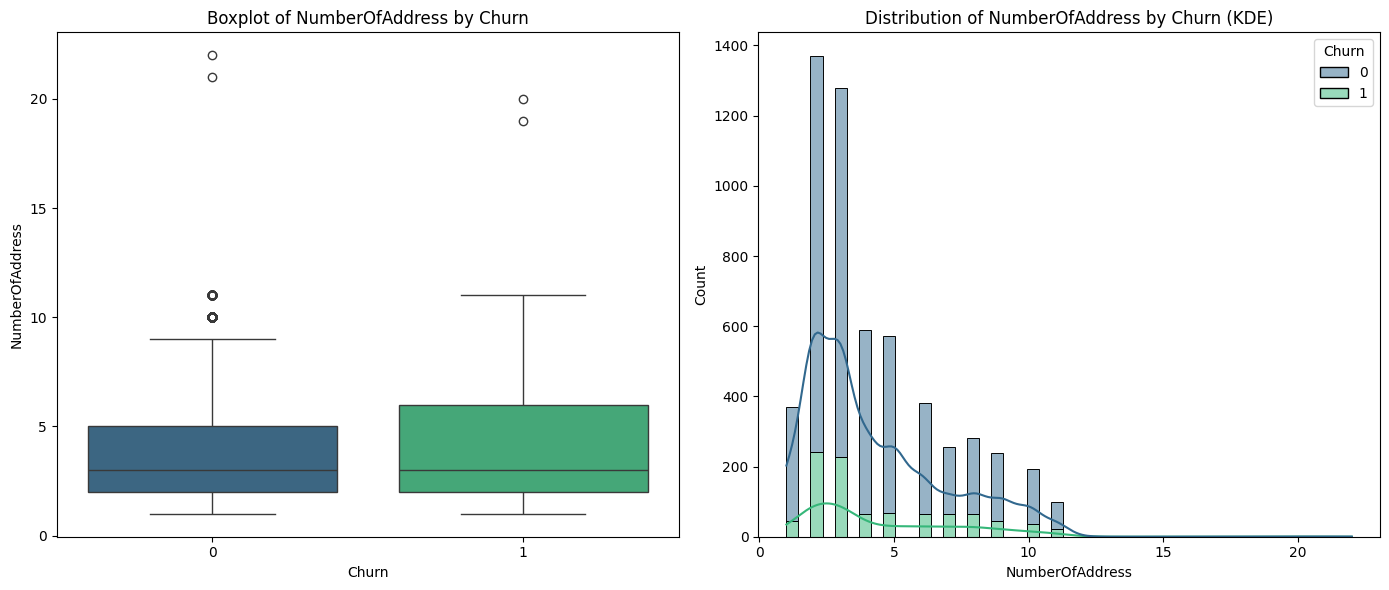

In [87]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfAddress')

#### OrderAmountHikeFromlastYear

==================== Analyzing OrderAmountHikeFromlastYear by Churn ====================



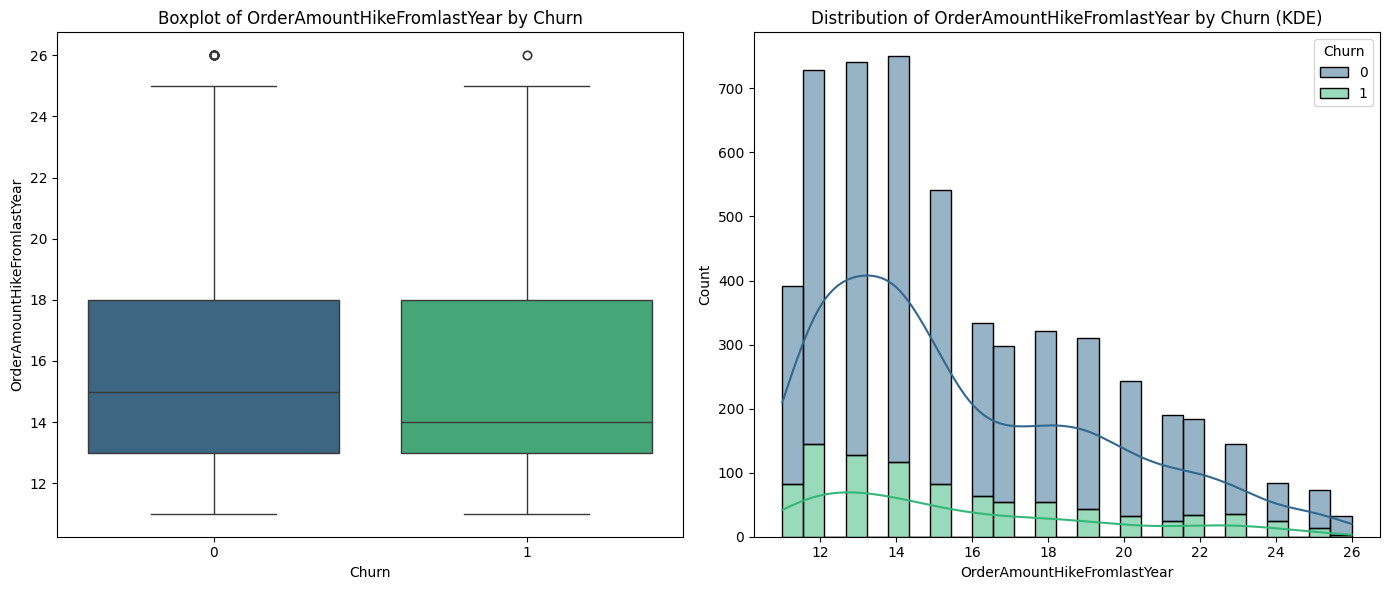

In [88]:
analyze_numerical_by_churn(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### CouponUsed

==================== Analyzing CouponUsed by Churn ====================



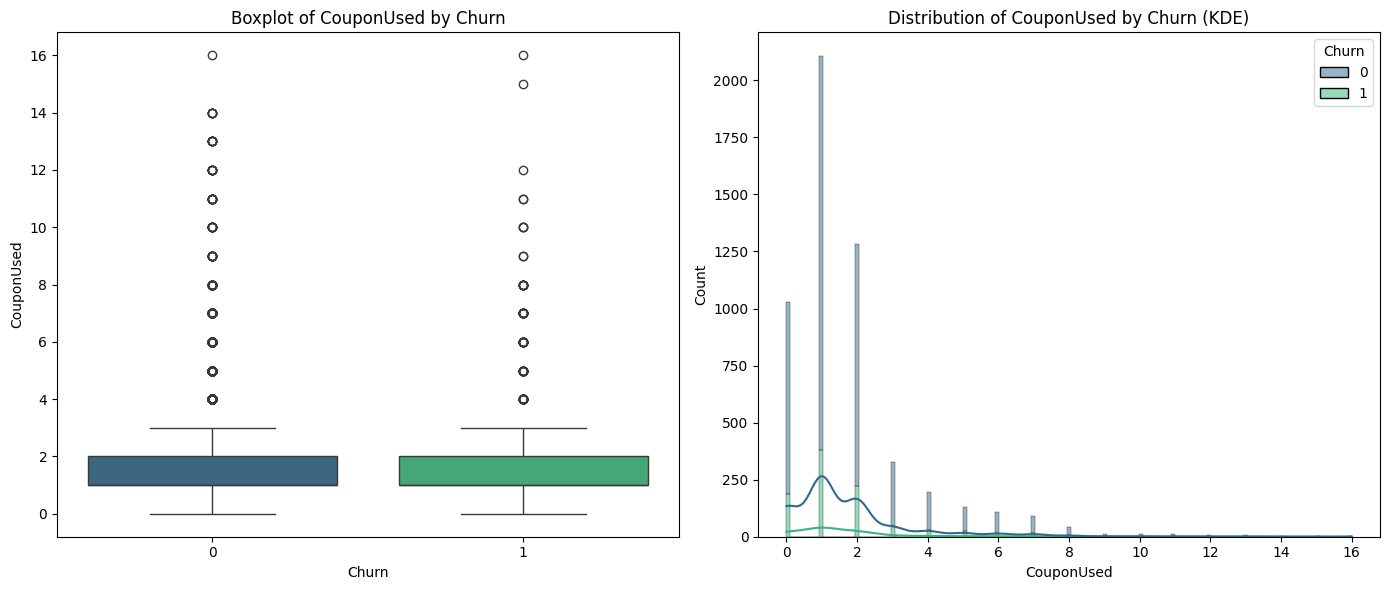

In [89]:
analyze_numerical_by_churn(df_ecommerce, 'CouponUsed')

For coupon used, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### OrderCount

==================== Analyzing OrderCount by Churn ====================



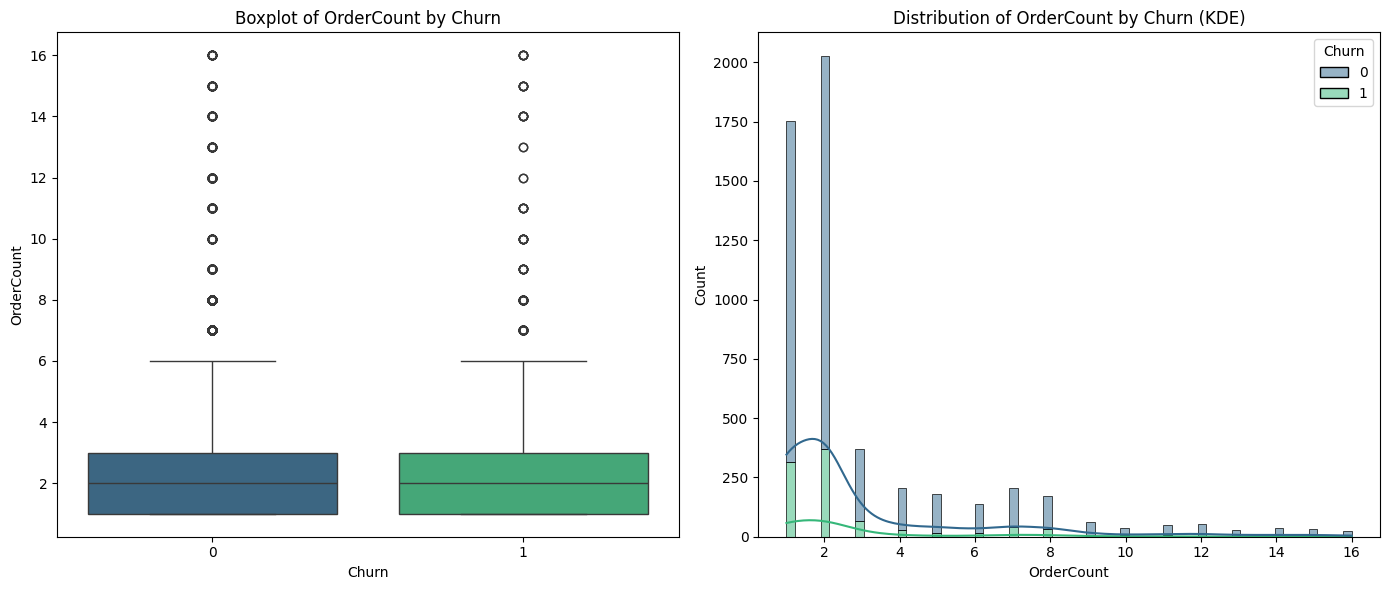

In [90]:
analyze_numerical_by_churn(df_ecommerce, 'OrderCount')

For order count, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### DaySinceLastOrder

==================== Analyzing DaySinceLastOrder by Churn ====================



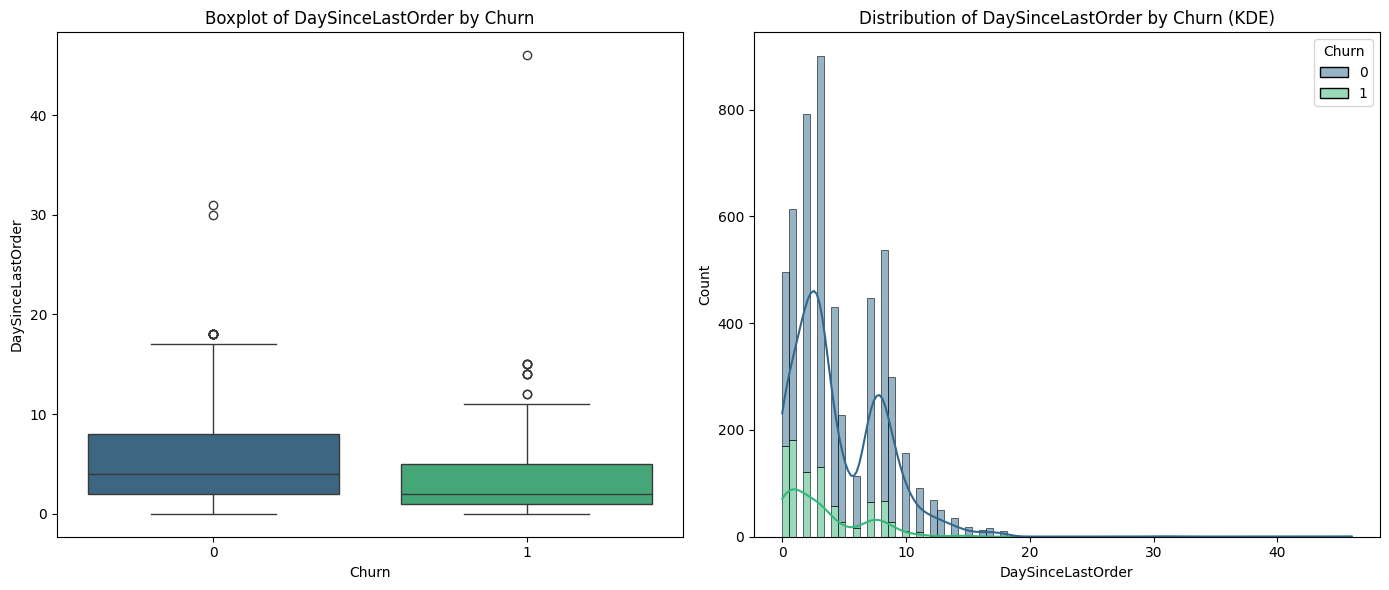

In [91]:
analyze_numerical_by_churn(df_ecommerce, 'DaySinceLastOrder')

Customers who have not churned have a **wider range** of days since their last order, but the majority of churning customers have a very **recent last order** (typically within the first 5 days). This could indicate that customers are leaving shortly after a recent poor experience.

#### CashbackAmount

==================== Analyzing CashbackAmount by Churn ====================



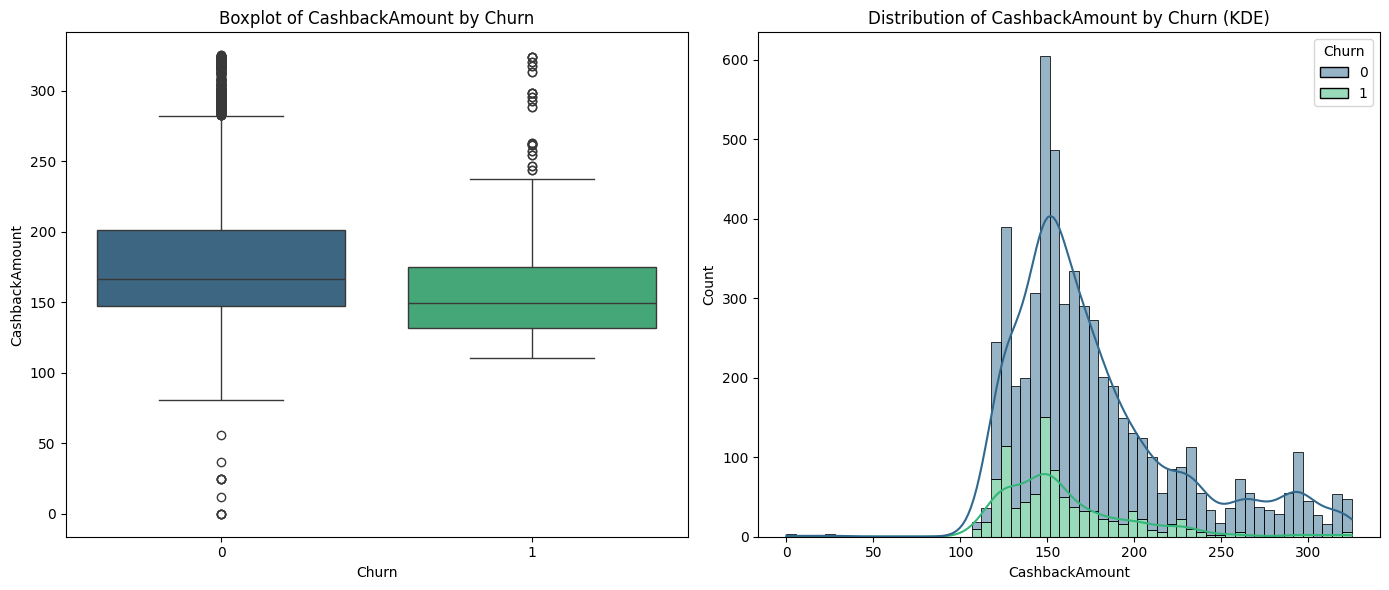

In [92]:
analyze_numerical_by_churn(df_ecommerce, 'CashbackAmount')

The median cashback amount is noticeably **lower** for churning customers compared to non-churning customers. This suggests that a higher cashback amount may be a factor in retaining customers.

## 3.6. In-depth Categorical Analysis

In [93]:
# Define all categorical features to analyze
categorical_features = df_ecommerce.select_dtypes(include='object').columns.tolist()
ordinal_binary_features = ['CityTier', 'SatisfactionScore', 'Complain']
all_categorical = categorical_features + ordinal_binary_features

### 3.6.1. Univariate

In [94]:
def analyze_univariate_categorical(df_ecommerce, all_categorical):
    """
    Analyzes and visualizes each categorical feature in a DataFrame
    by generating a countplot and a pie chart.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame.
    - all_categorical (list): A list of categorical column names.
    """
    for col in all_categorical:
        print(f'\nAnalyzing Univariate Feature: {col}')
        
        # Check for "super minority" classes (e.g., less than 1% of the total)
        total_count = len(df_ecommerce[col])
        value_counts = df_ecommerce[col].value_counts(normalize=True)
        minority_classes = value_counts[value_counts < 0.01].index.tolist()
        
        if minority_classes:
            print(f"Warning: The following classes in '{col}' are super minority classes (<1%): {minority_classes}")
            print("Consider grouping these classes for better analysis/modeling.")

        plt.figure(figsize=(18, 7))

        # Subplot 1: Countplot for absolute counts
        plt.subplot(1, 2, 1)
        ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')
        plt.title(f'Count of {col}', fontsize=15)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        for p in ax.patches:
            width = p.get_width()
            plt.text(width + 20, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

        # Subplot 2: Pie chart for proportions
        plt.subplot(1, 2, 2)
        counts = df_ecommerce[col].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(counts)))
        plt.title(f'Proportion of {col}', fontsize=15)
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        
        plt.tight_layout()
        plt.show()

#### PreferredLoginDevice


Analyzing Univariate Feature: PreferredLoginDevice


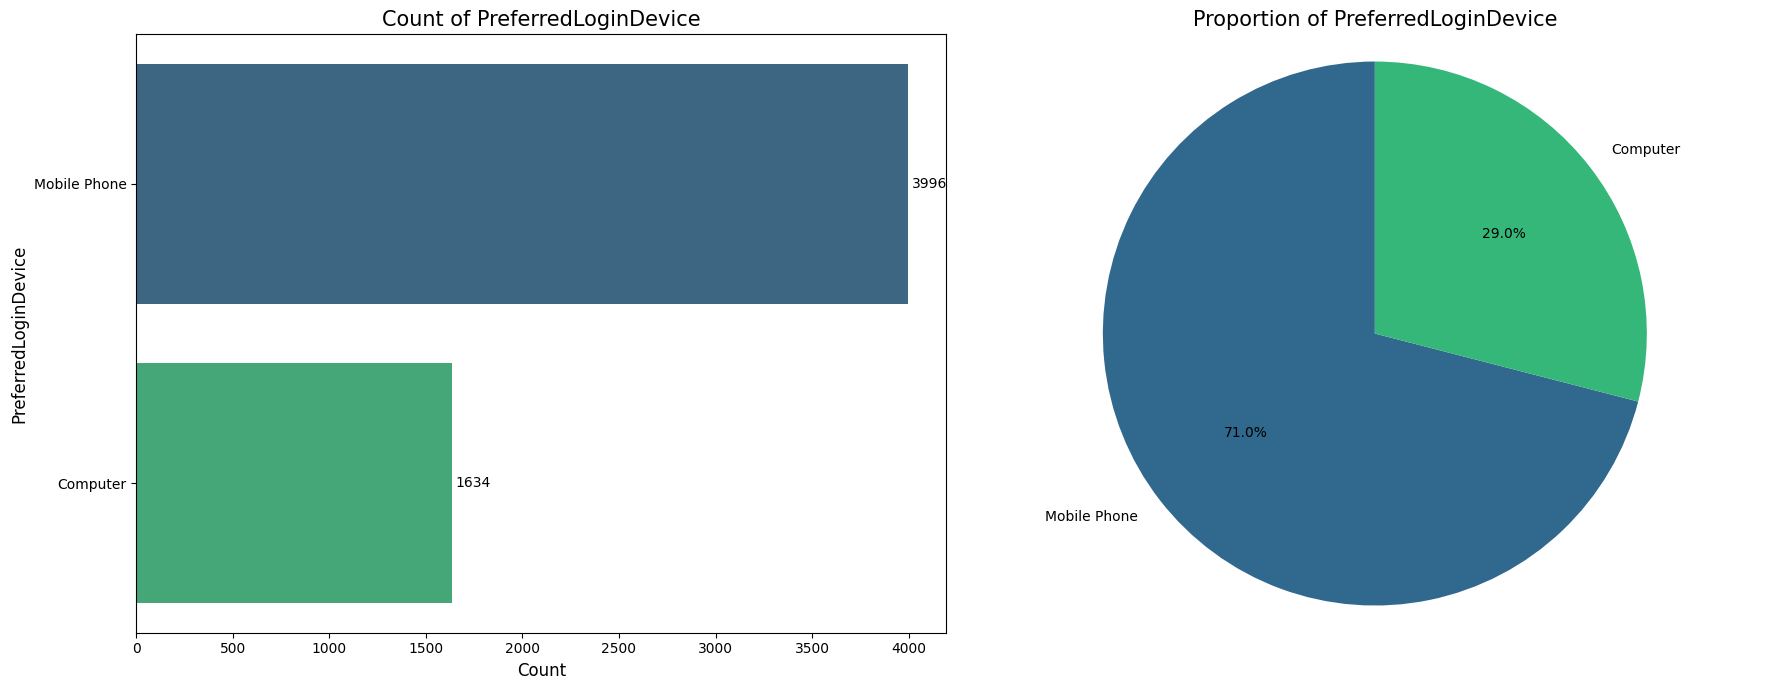

In [95]:
analyze_univariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

- **Mobile Phone dominates (71%)** vs Computer (29%).

#### PreferredPaymentMode


Analyzing Univariate Feature: PreferredPaymentMode


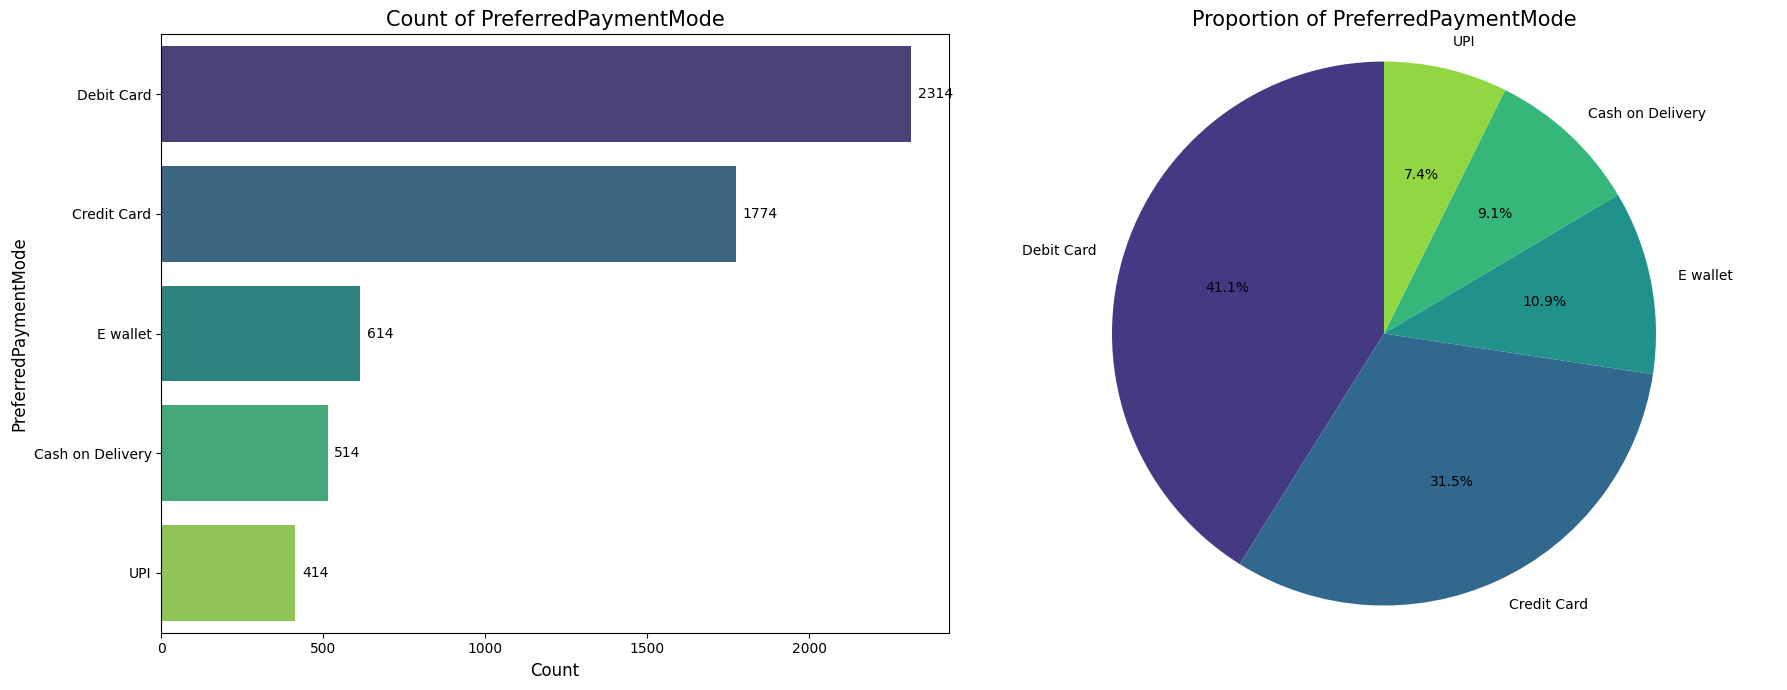

In [96]:
analyze_univariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

- **Debit card leads (41%)**  
- Credit card (32%)  
- Digital wallets (~11%)  
- Cash on Delivery (~9%)  
- UPI (7%)  
➡️ Customers prefer **cards over wallets/UPI**

#### Gender


Analyzing Univariate Feature: Gender


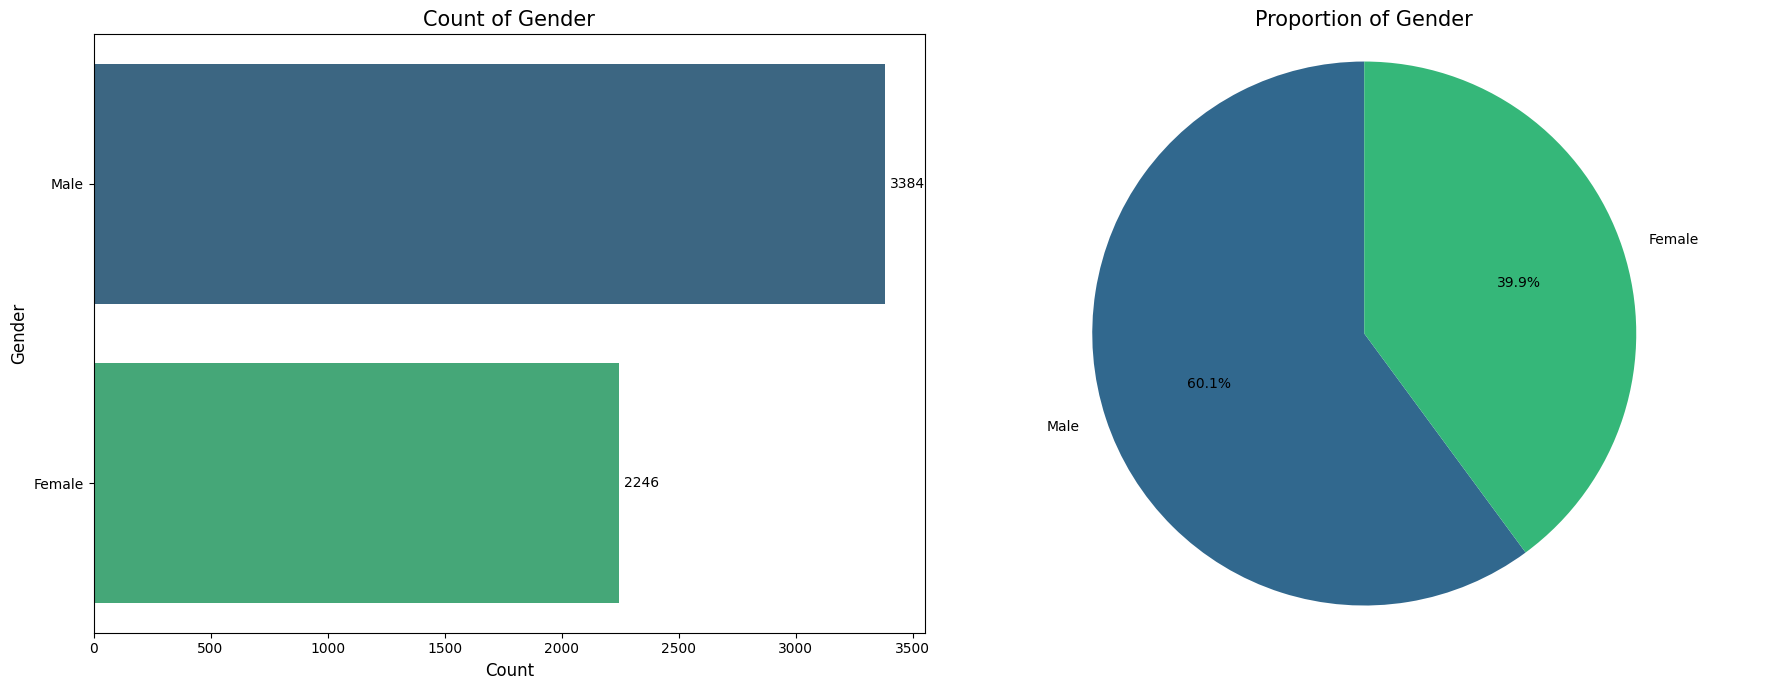

In [97]:
analyze_univariate_categorical(df_ecommerce, ['Gender'])

- Male ~60%  
- Female ~40%  
➡️ A bit male-dominated customer base, but still a significant female segment.

#### PreferedOrderCat


Analyzing Univariate Feature: PreferedOrderCat


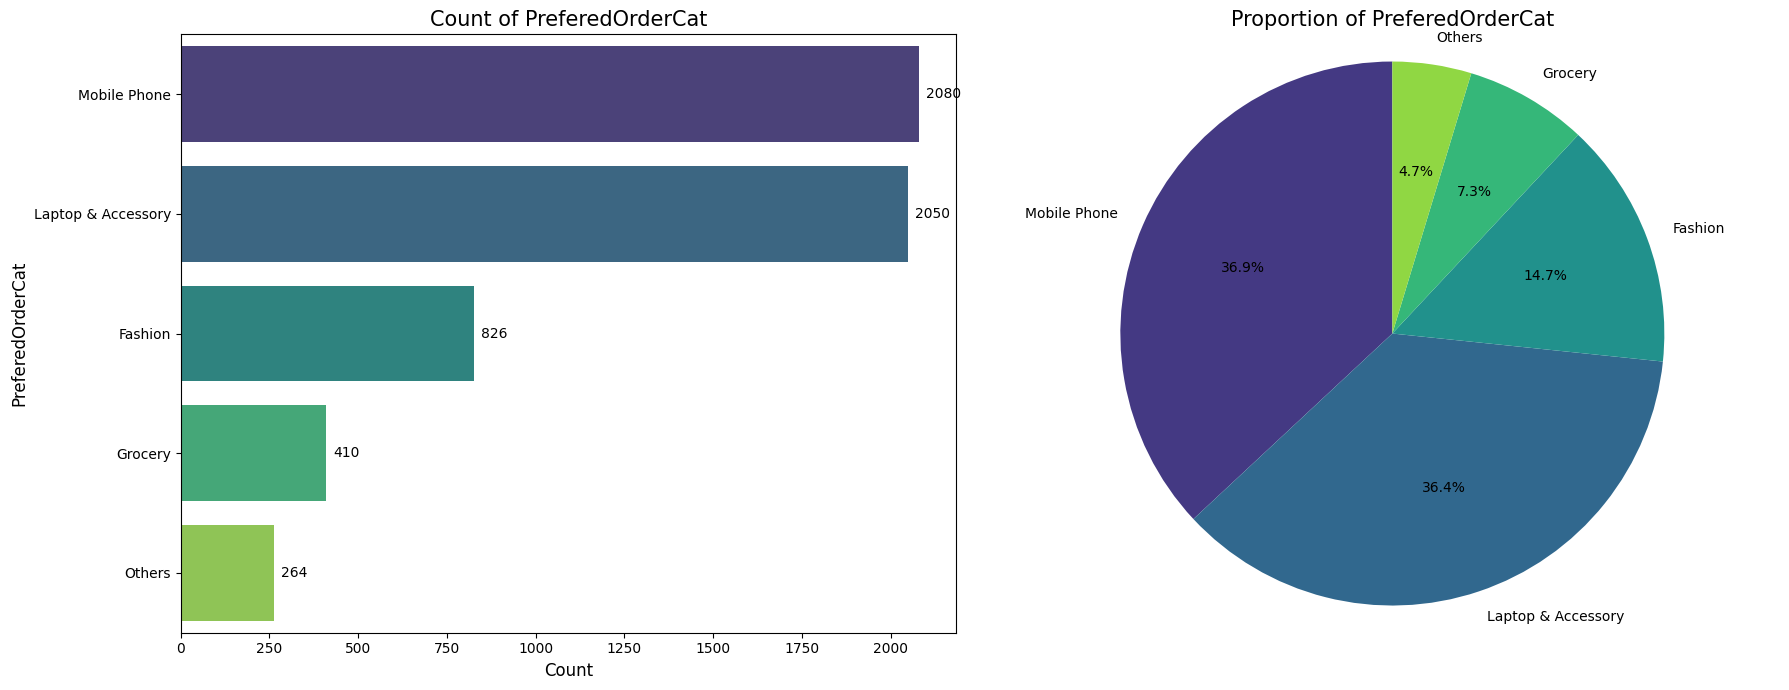

In [98]:
analyze_univariate_categorical(df_ecommerce, ['PreferedOrderCat'])

- **Mobile Phones (37%)**  
- **Laptop & Accessories (36%)**  
- Fashion (~15%)  
- Grocery (~7%)  
- Others (~5%)  
➡️ Electronics dominate; fashion & groceries are **under-penetrated growth opportunities**.

#### MaritalStatus


Analyzing Univariate Feature: MaritalStatus


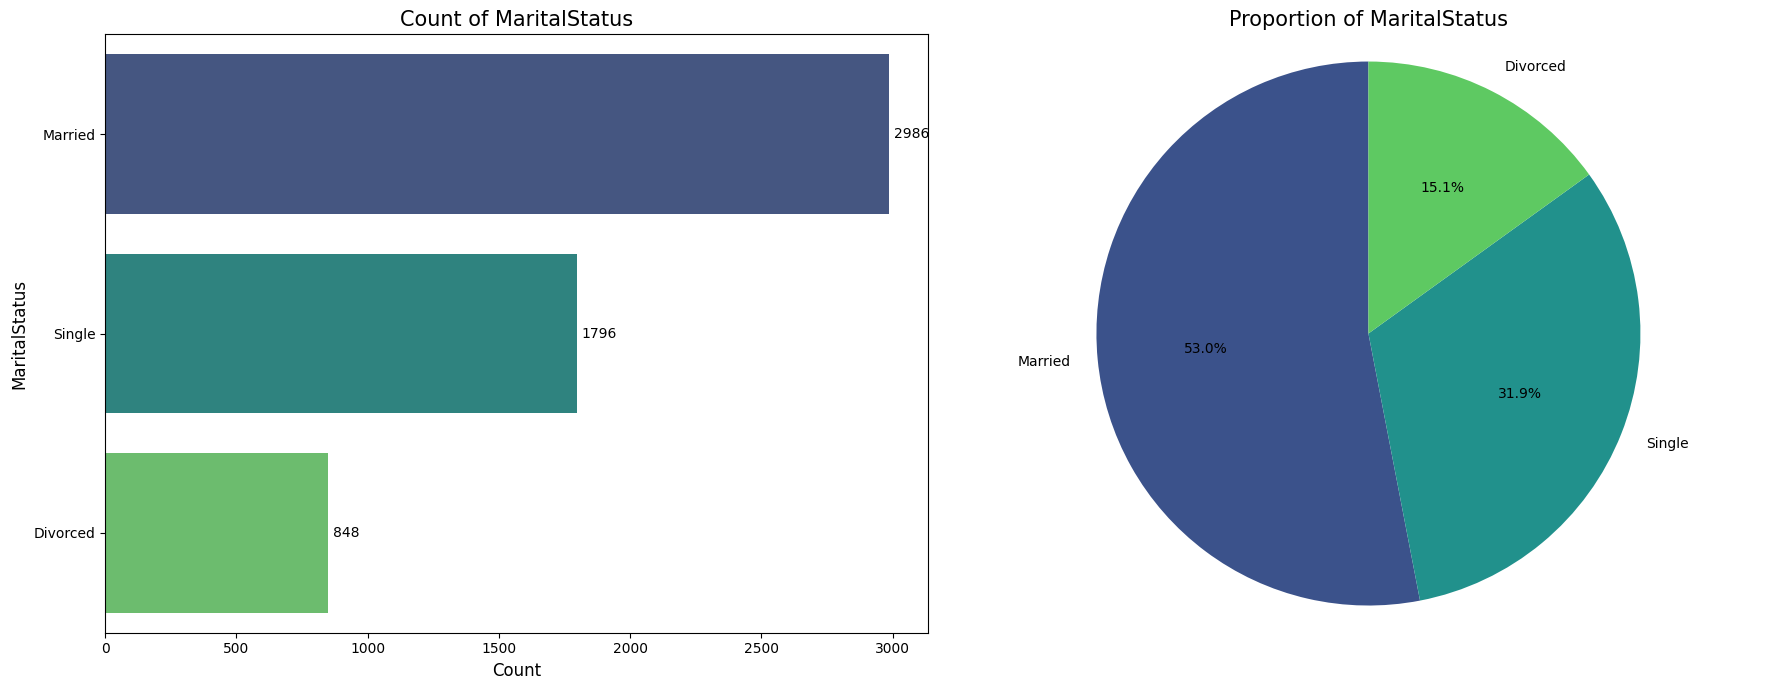

In [99]:
analyze_univariate_categorical(df_ecommerce, ['MaritalStatus'])

- the majority of customers are married, accounting for 53% of the total. Single customers are the next largest group at 31.9%, while divorced customers represent the smallest segment at 15.1%.

#### CityTier


Analyzing Univariate Feature: CityTier


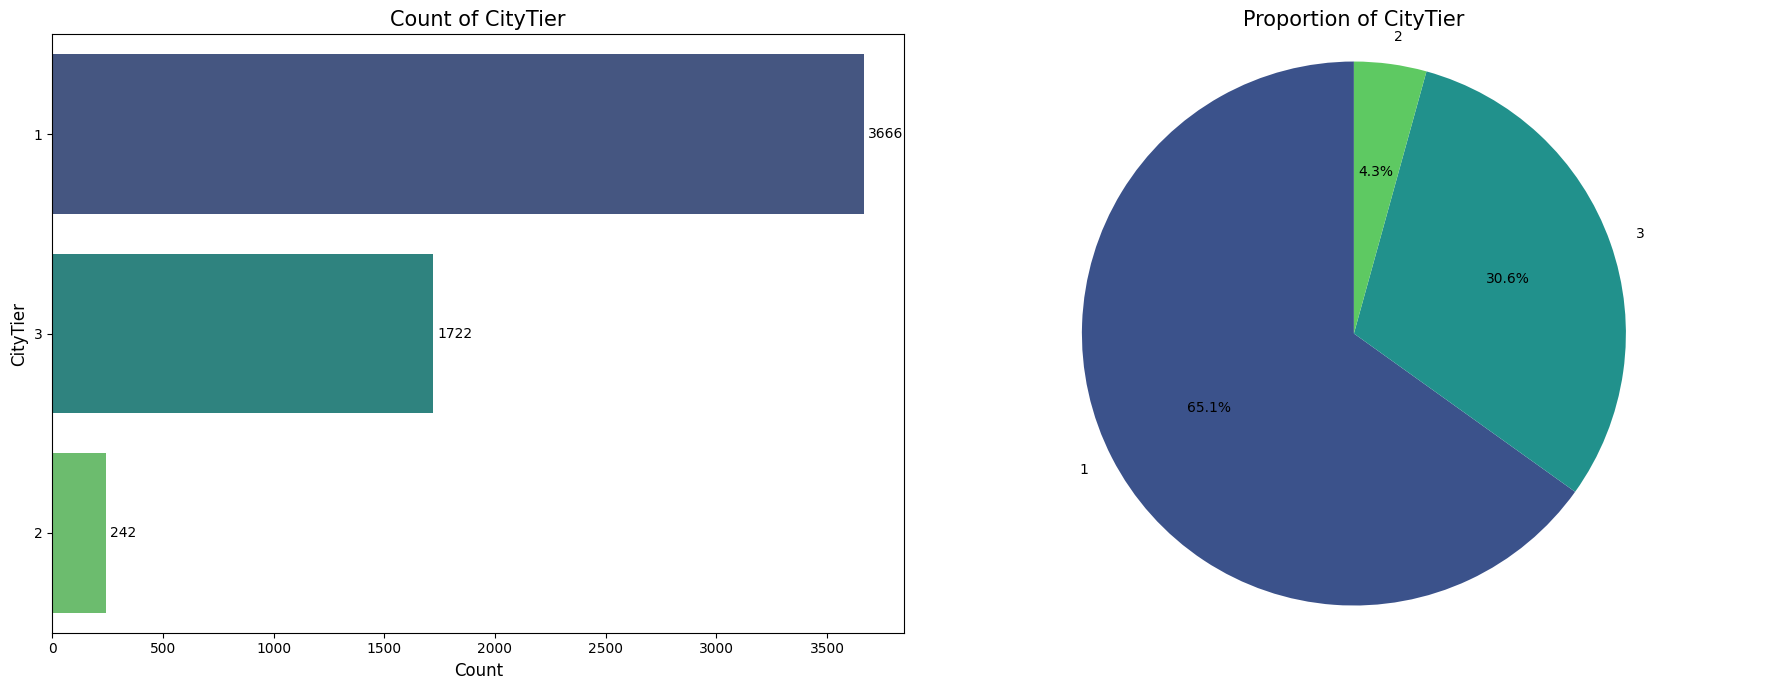

In [100]:
analyze_univariate_categorical(df_ecommerce, ['CityTier'])

- **Tier 1 cities dominate** with ~65% of customers.  
- Tier 3 contributes ~31%, while Tier 2 is very small (~4%).  
➡️ Most customers are concentrated in Tier 1 cities

#### SatisfactionScore


Analyzing Univariate Feature: SatisfactionScore


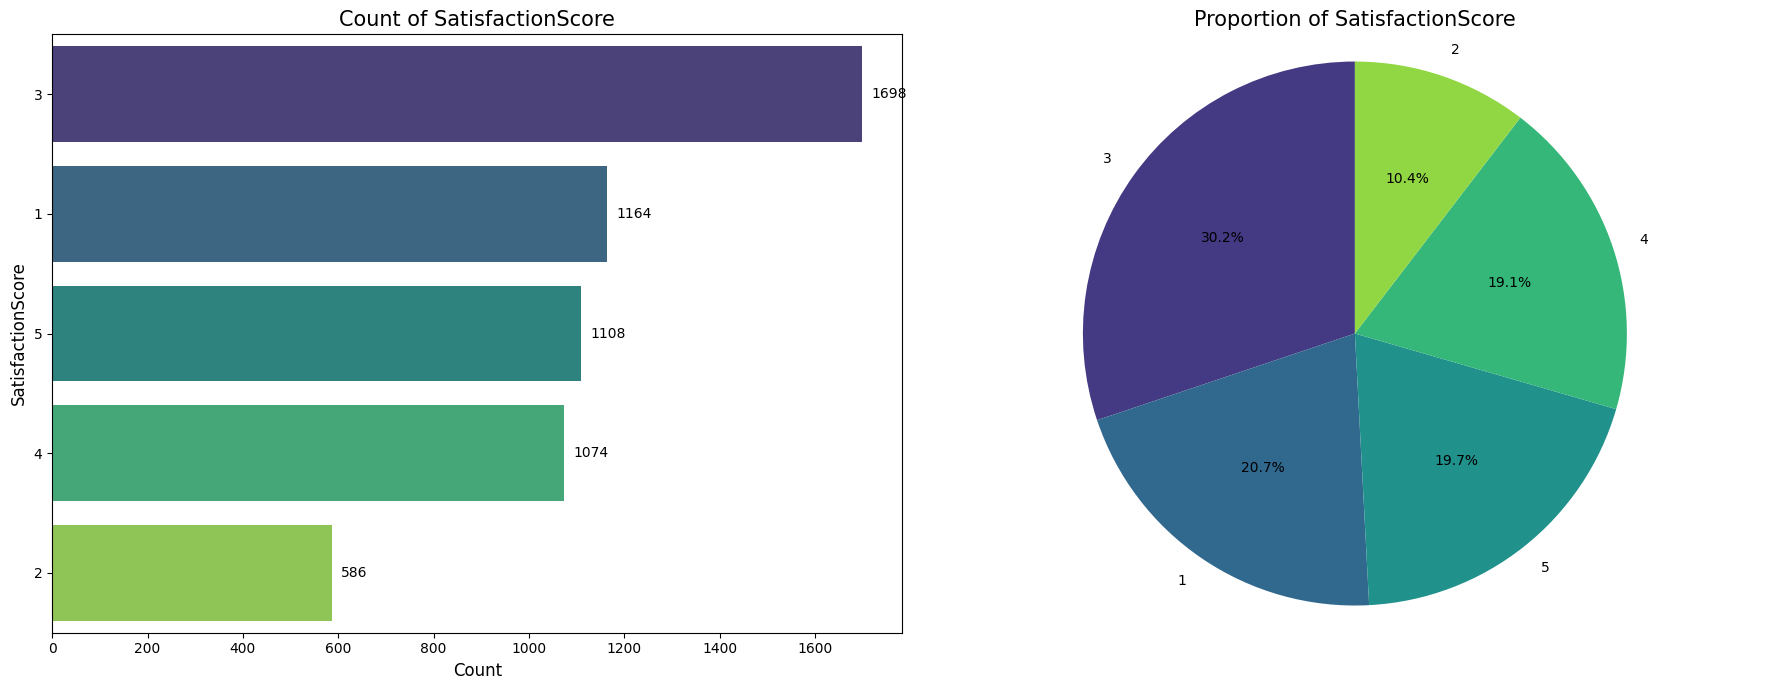

In [101]:
analyze_univariate_categorical(df_ecommerce, ['SatisfactionScore'])

- Score **3 is the most common** (~30%), suggesting many customers are neutral.

#### Complain


Analyzing Univariate Feature: Complain


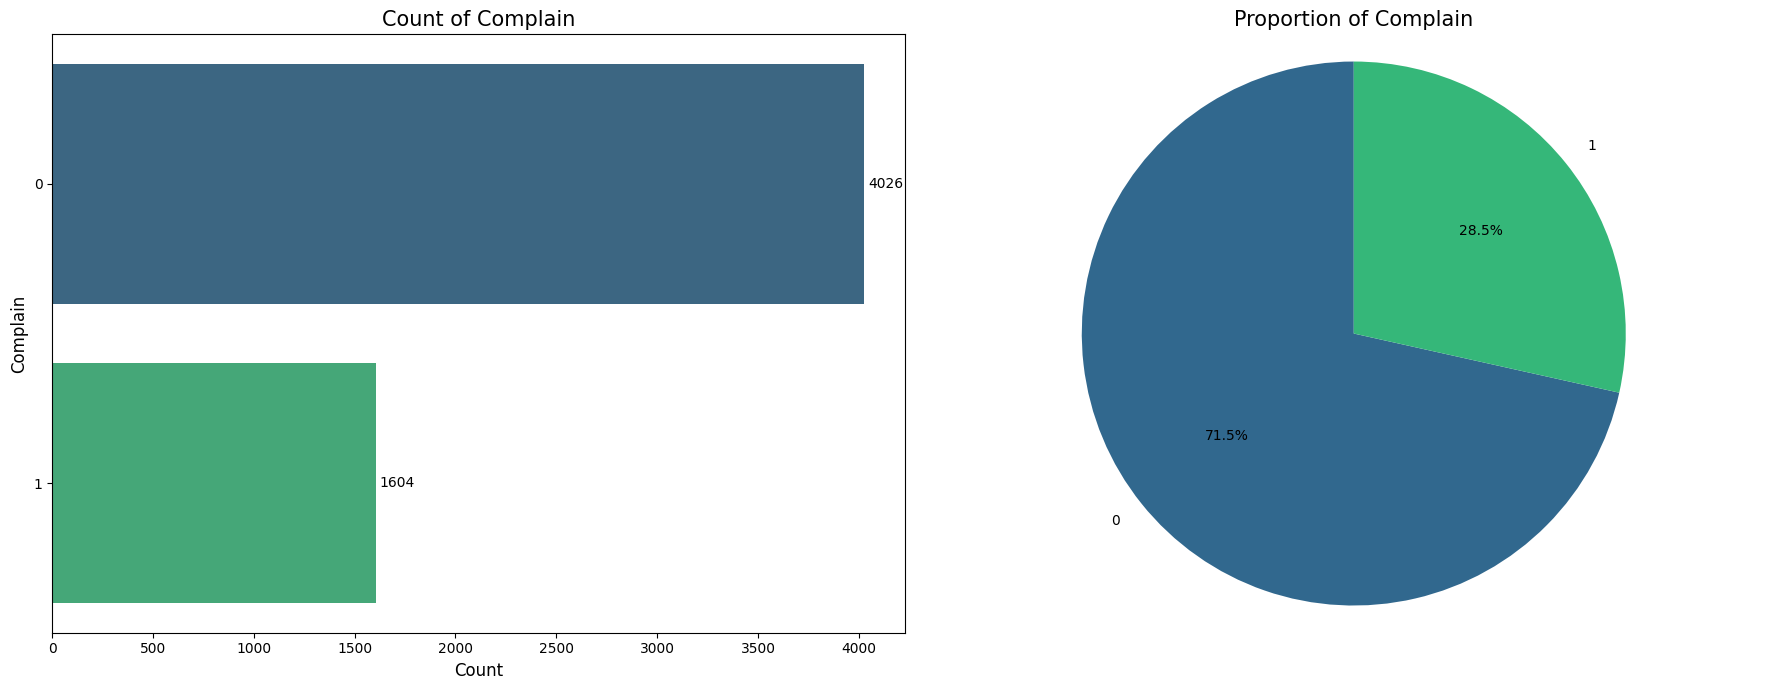

In [102]:
analyze_univariate_categorical(df_ecommerce, ['Complain'])

- **71% have not complained**, but **29% have**.

➡️ A relatively high complaint rate

### 3.6.2. Bivariate

In [103]:
def analyze_bivariate_categorical(df_ecommerce, all_categorical):
    """
    Performs bivariate analysis between categorical features and the 'Churn' target.
    
    For each categorical column, it generates:
    - A stacked bar chart showing the proportion of Churn for each category.
    - A countplot showing the absolute counts of Churn and No Churn for each category.
    - A Chi-squared test to determine if there is a statistically significant association.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame containing the features and 'Churn' column.
    - all_categorical (list): A list of categorical column names to analyze.
    """
    # Label + color mapping (don’t modify df, just for plotting)
    label_map = {0: "No Churn", 1: "Churn"}
    complain_map = {0: "No", 1: "Yes"}
    
    # Flexible palette: works with both raw and mapped values
    palette = {
        0: "#42a5f5",   # No Churn (numeric)
        1: "#ef5350",   # Churn (numeric)
        "No": "#42a5f5",
        "Yes": "#ef5350",
        "No Churn": "#42a5f5",
        "Churn": "#ef5350"
    }

    for col in all_categorical:
        print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

        # If column is Complain, create a copy with mapped labels
        if col == "Complain":
            df_plot = df_ecommerce.copy()
            df_plot[col] = df_plot[col].map(complain_map)
        else:
            df_plot = df_ecommerce

        # --- Proportion table ---
        churn_proportion = (
            df_plot.groupby(col)['Churn']
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
        )

        # Rename columns just for plotting
        churn_proportion = churn_proportion.rename(columns=label_map)

        # Ensure both churn categories exist
        for cat in ["Churn", "No Churn"]:
            if cat not in churn_proportion.columns:
                churn_proportion[cat] = 0

        # Reorder so Churn is bottom
        churn_proportion = churn_proportion[["Churn", "No Churn"]]

        # Sort by churn rate
        churn_proportion = churn_proportion.sort_values(by="Churn", ascending=False)

        # --- Subplots ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # --- 1. Stacked bar (proportions) ---
        churn_proportion.plot(
            kind="bar",
            stacked=True,
            color=[palette["Churn"], palette["No Churn"]],
            ax=axes[0]
        )

        axes[0].set_title(f'Proportion of Churn by {col}', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Proportion (%)', fontsize=12)
        axes[0].set_ylim(0, 1)
        axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])
        axes[0].legend(title='Churn', labels=["Churn", "No Churn"])

        # Add percentage labels
        for container in axes[0].containers:
            labels = [f'{v.get_height():.0%}' if v.get_height() > 0 else '' for v in container]
            axes[0].bar_label(container, labels=labels, label_type='center', fontsize=9)

        # --- 2. Countplot (sorted by churn count) ---
        churn_counts = (
            df_plot.groupby(col)["Churn"]
            .value_counts()
            .unstack(fill_value=0)
        )

        # Sort categories by descending churn count
        order_by_churn = churn_counts.sort_values(1, ascending=False).index

        ax = sns.countplot(
            data=df_plot,
            x=col,
            hue="Churn",
            order=order_by_churn,
            palette=palette,
            ax=axes[1]
        )

        # Fix legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label_map.get(int(lbl), lbl) for lbl in labels]
        ax.legend(handles, new_labels, title="Churn")

        ax.set_title(f"Count of {col} by Churn", fontsize=14)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.tick_params(axis="x", rotation=45)

        # Add count labels
        for container in ax.containers:
            ax.bar_label(container, fmt="%d", fontsize=9)

        plt.tight_layout()
        plt.show()

        # Chi-squared Test for Association
        contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        
        print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
        
        if p < 0.05:
            print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
        else:
            print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
            
        print("-" * 50)

#### PreferredLoginDevice


Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


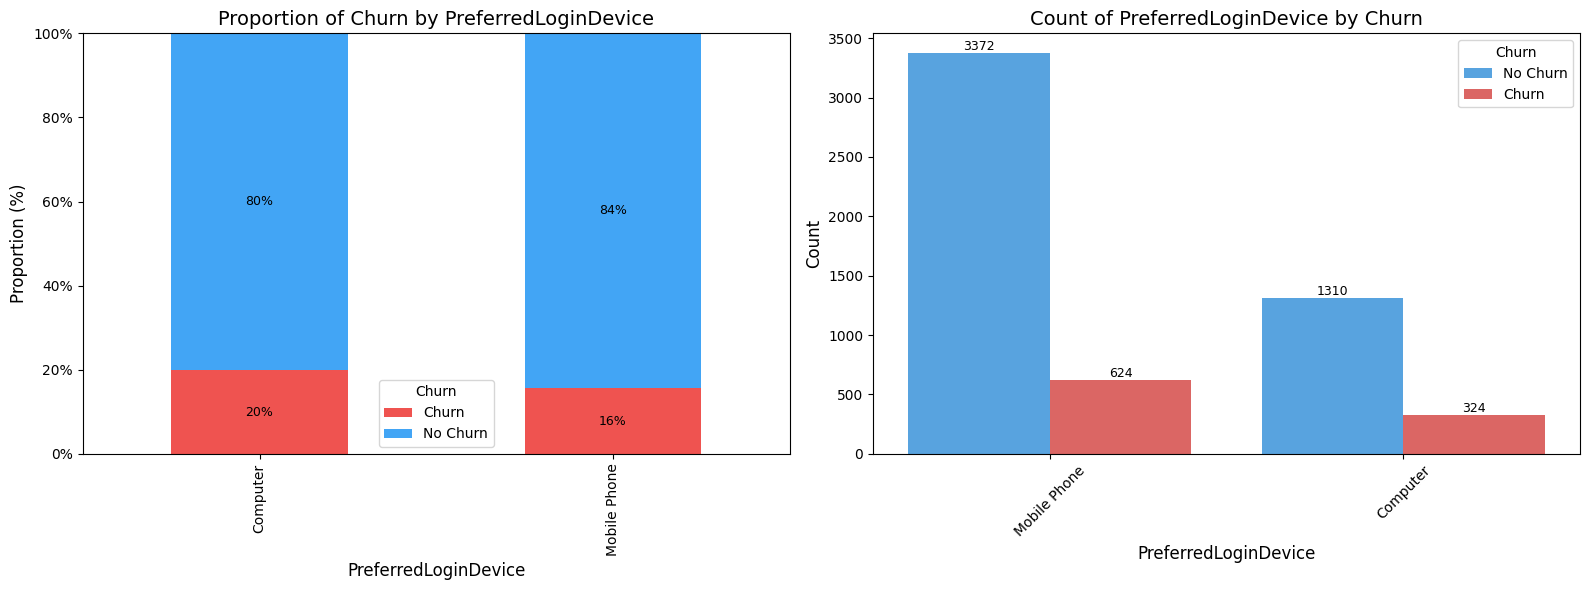

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------


In [104]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

Customers who prefer to use a "Computer" to log in have a higher churn rate (**19.8%**) than those who use a "Mobile Phone" (**15.6%**).

#### PreferredPaymentMode


Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


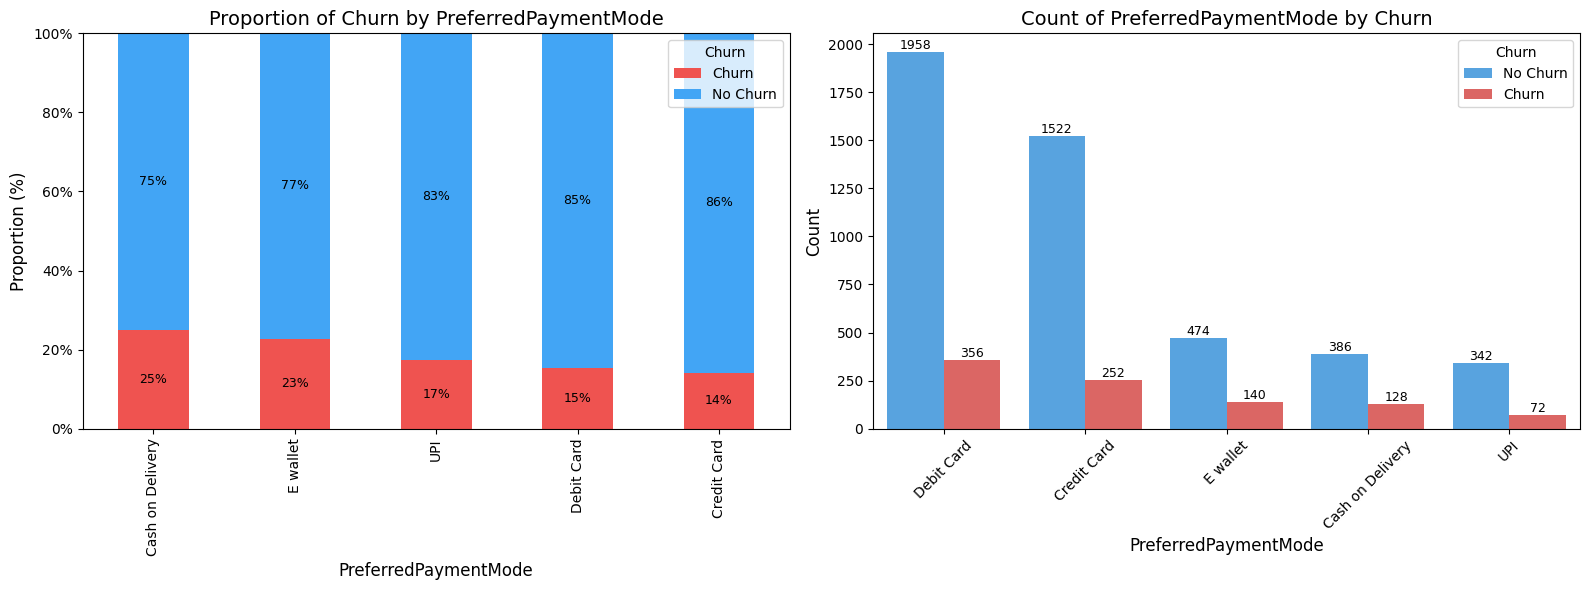

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------


In [105]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

"Cash on Delivery" has the highest churn rate at **24.9%**. This is a potential red flag, as it's the only payment method with a churn rate over 20%. Other methods like Credit Card, Debit Card, E-wallet, and UPI have lower, more consistent churn rates.

#### Gender


Analyzing Bivariate Feature: Gender vs. Churn


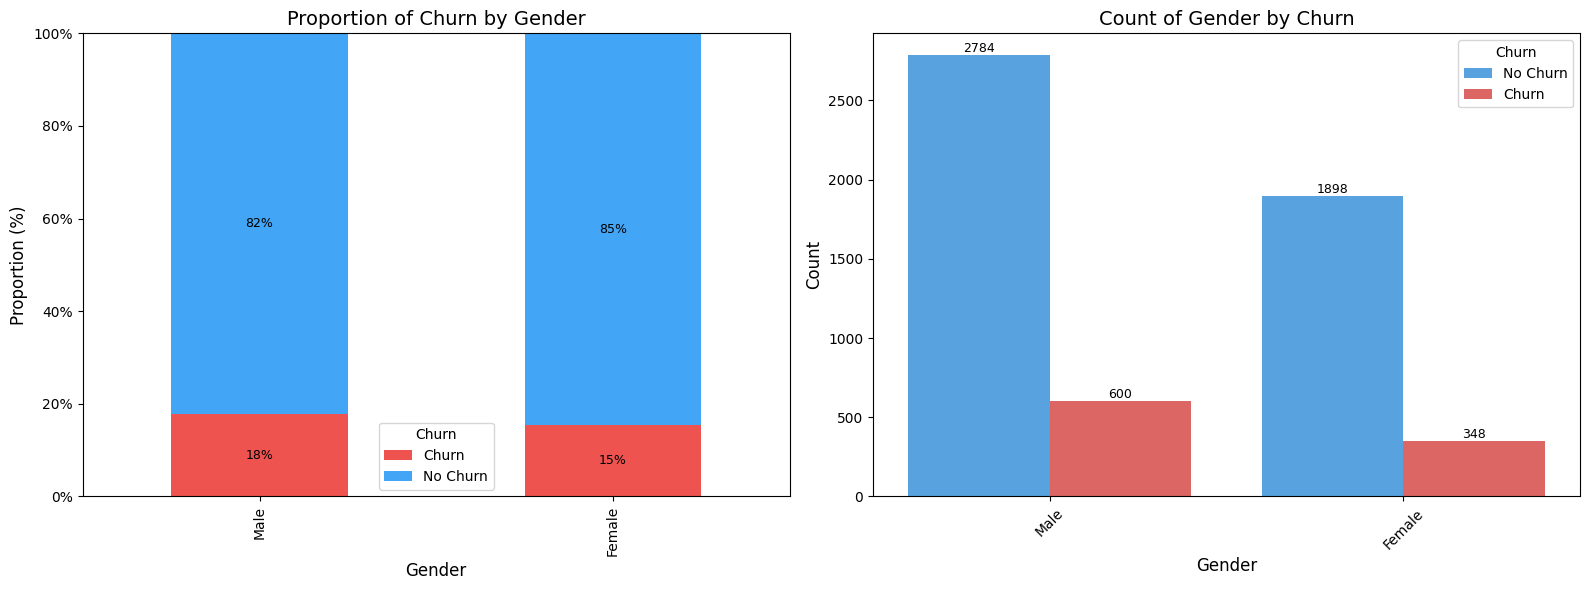

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------


In [106]:
analyze_bivariate_categorical(df_ecommerce, ['Gender'])

Churn rates are similar across genders, with females at **15.5%** and males at **17.7%**. This suggests that gender is not a major factor in predicting churn.

#### PreferedOrderCat


Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


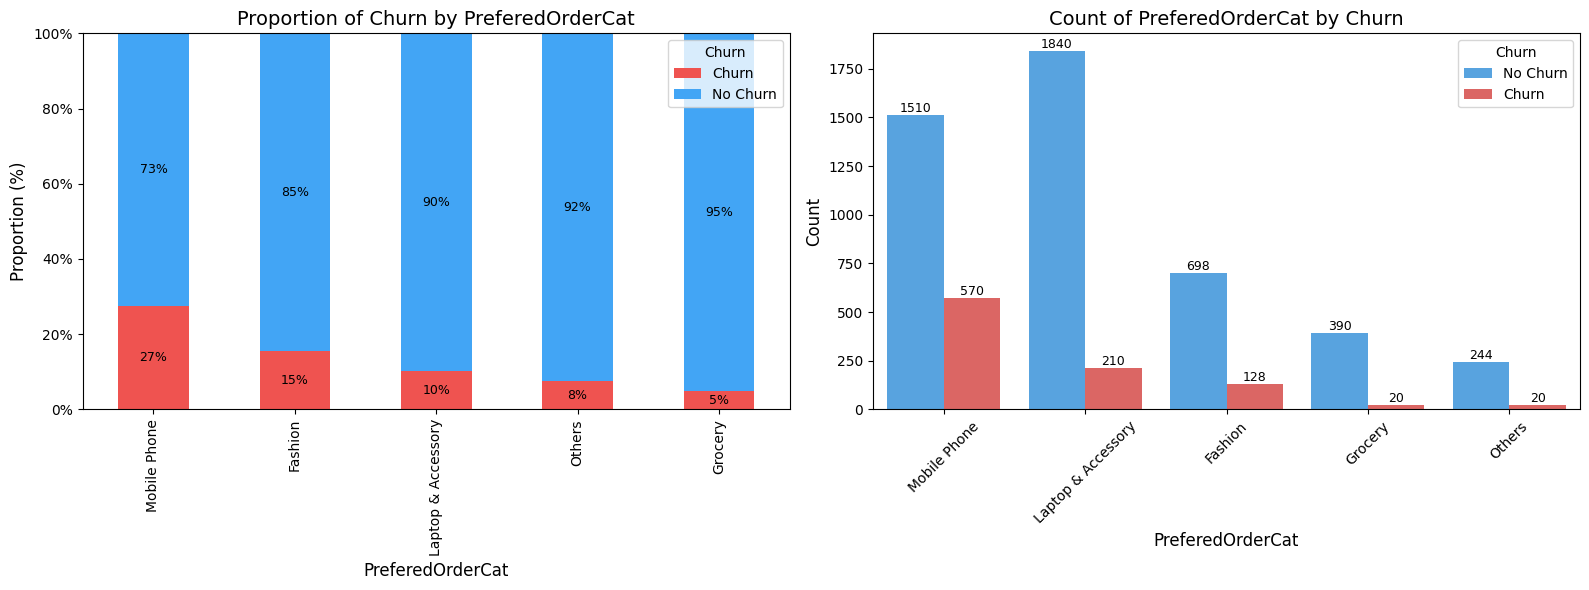

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------


In [107]:
analyze_bivariate_categorical(df_ecommerce, ['PreferedOrderCat'])

"Mobile Phone" orders have a very high churn rate of **27.4%**, which is significantly higher than any other category. "Grocery" orders have the lowest churn rate at **4.9%**.

#### MaritalStatus


Analyzing Bivariate Feature: MaritalStatus vs. Churn


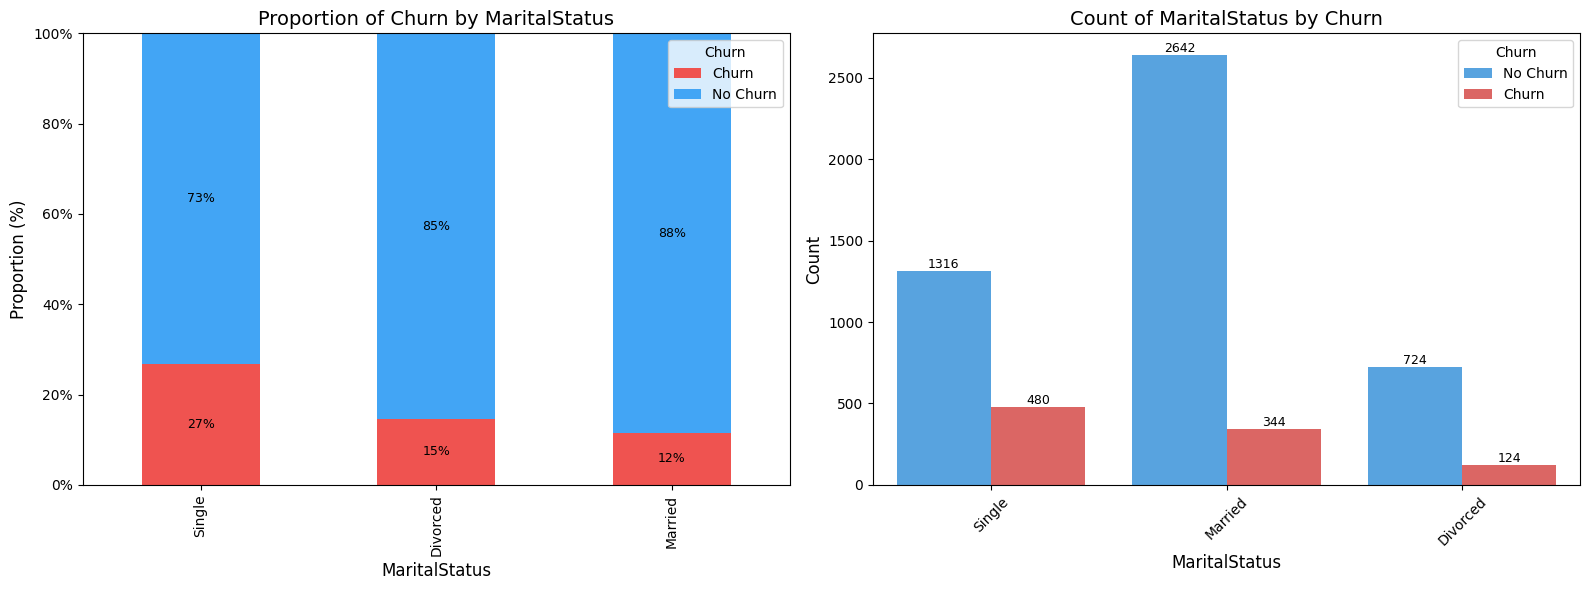

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------


In [108]:
analyze_bivariate_categorical(df_ecommerce, ['MaritalStatus'])

Single customers have the highest churn rate at **26.7%**, significantly higher than divorced (**14.6%**) or married (**11.5%**) customers.

#### CityTier


Analyzing Bivariate Feature: CityTier vs. Churn


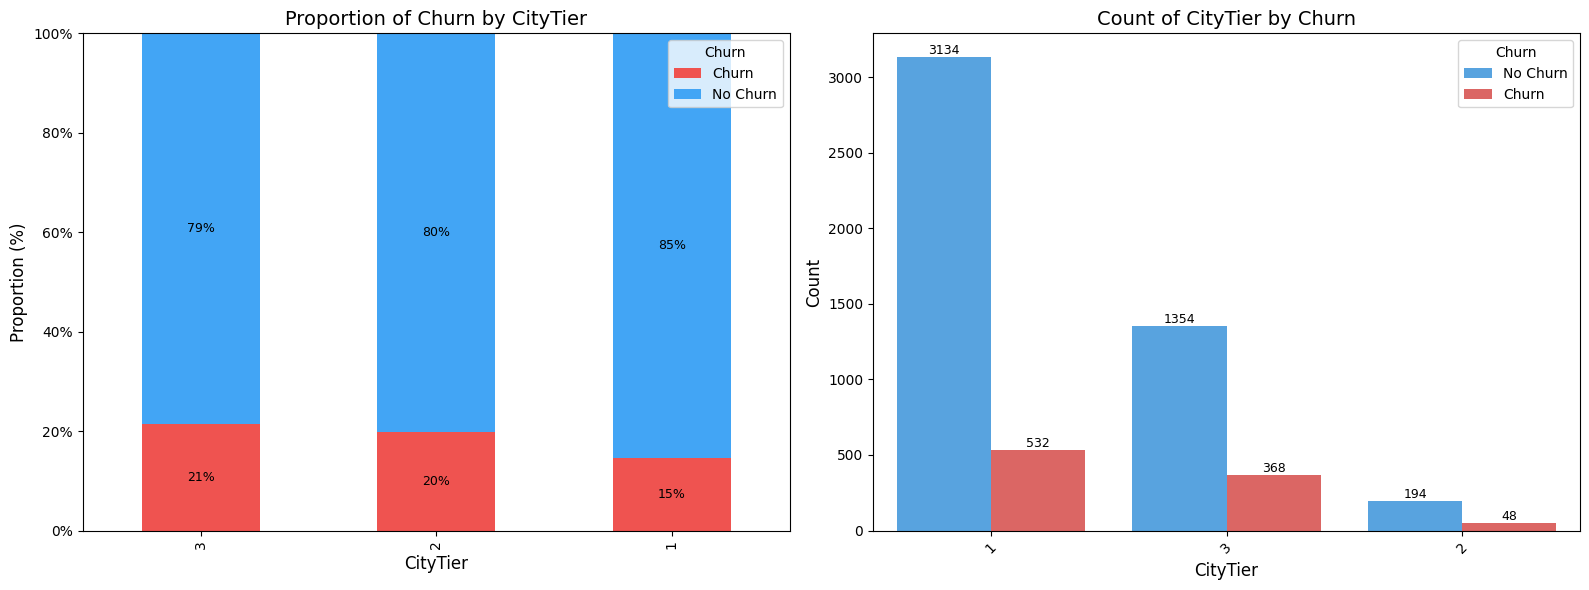

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------


In [109]:
analyze_bivariate_categorical(df_ecommerce, ['CityTier'])

Churn rates increase as the city tier number increases. Tier 1 cities have a churn rate of **14.5%**, Tier 2 at **19.8%**, and Tier 3 at **21.4%**.

#### SatisfactionScore


Analyzing Bivariate Feature: SatisfactionScore vs. Churn


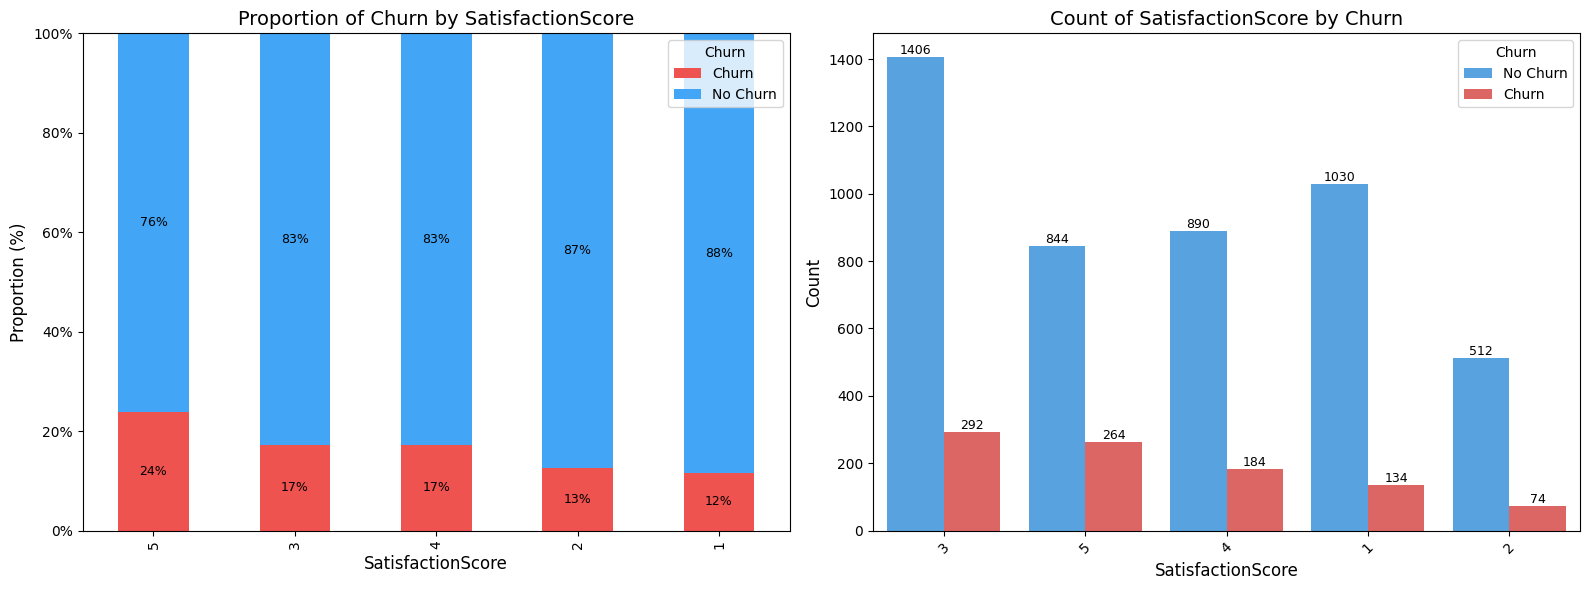

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------


In [110]:
analyze_bivariate_categorical(df_ecommerce, ['SatisfactionScore'])

There's a clear inverse relationship between satisfaction and churn. Customers with the lowest satisfaction score (1) have a churn rate of **11.5%**, while those with the highest score (5) have the highest churn rate at **23.8%**. This seemingly counterintuitive finding warrants further investigation as it is unclear the basis of scoring and may indicate that customers who are highly satisfied and then churn are doing so for reasons unrelated to satisfaction with the product/service itsel.

#### Complain


Analyzing Bivariate Feature: Complain vs. Churn


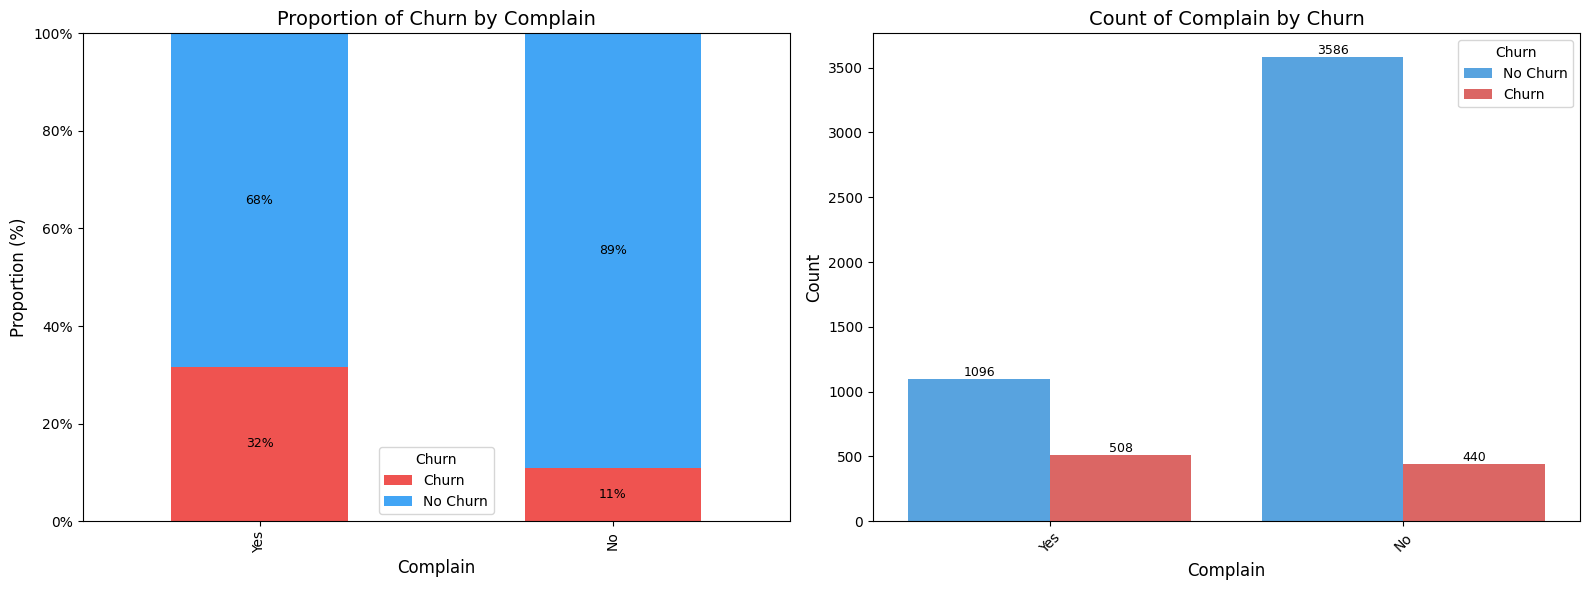

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [111]:
analyze_bivariate_categorical(df_ecommerce, ['Complain'])

A strong correlation exists between complaints and churn. Customers who complained (**31.7%**) are much more likely to churn compared to those who didn't (**10.9%**).

## 3.7. Missing Values Analysis

--- Starting Missing Values Analysis (Iterative by Feature) ---

Overall Missing values by column:
                             Total Missing  Percentage (%)
DaySinceLastOrder                      307        5.452931
OrderAmountHikeFromlastYear            265        4.706927
Tenure                                 264        4.689165
OrderCount                             258        4.582593
CouponUsed                             256        4.547069
HourSpendOnApp                         255        4.529307
WarehouseToHome                        251        4.458259


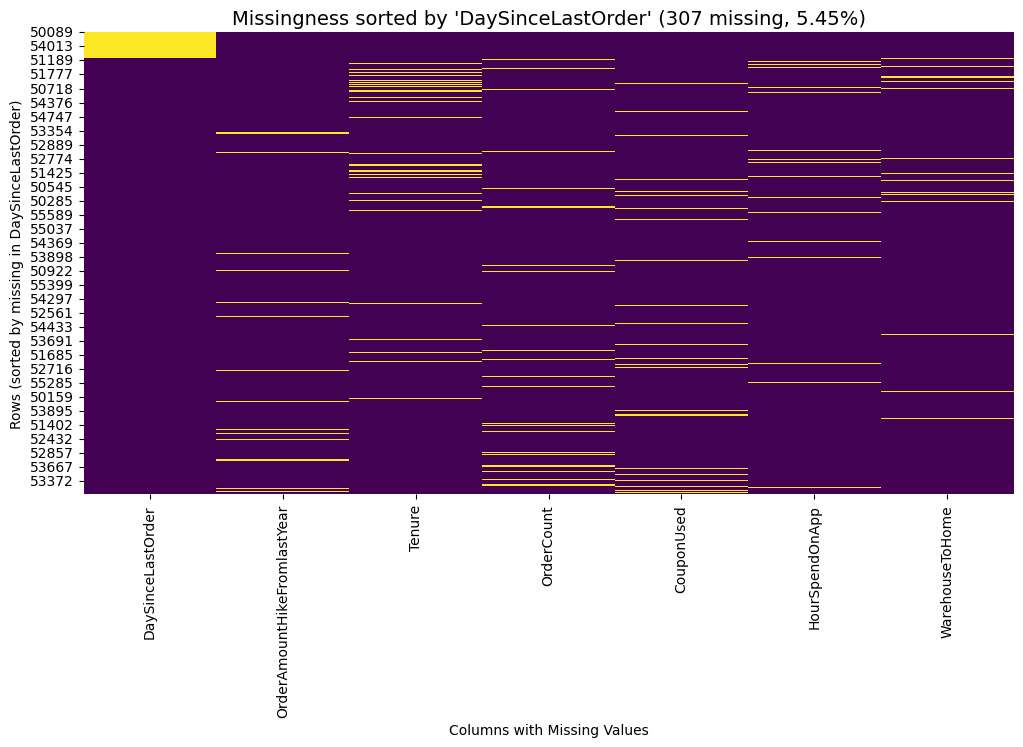

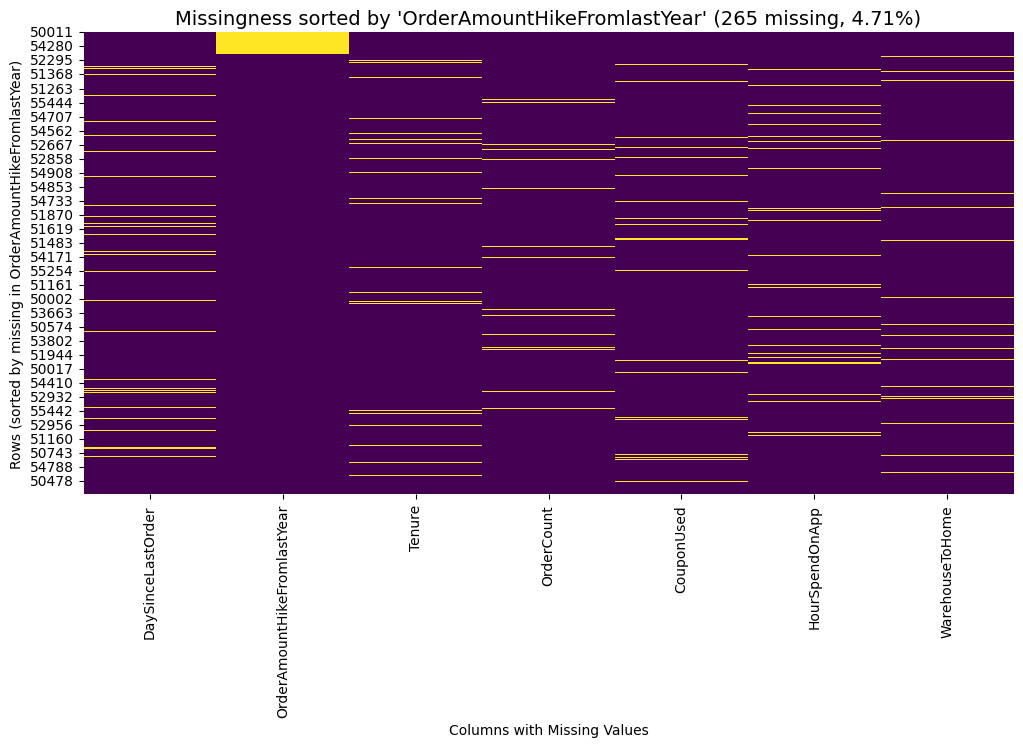

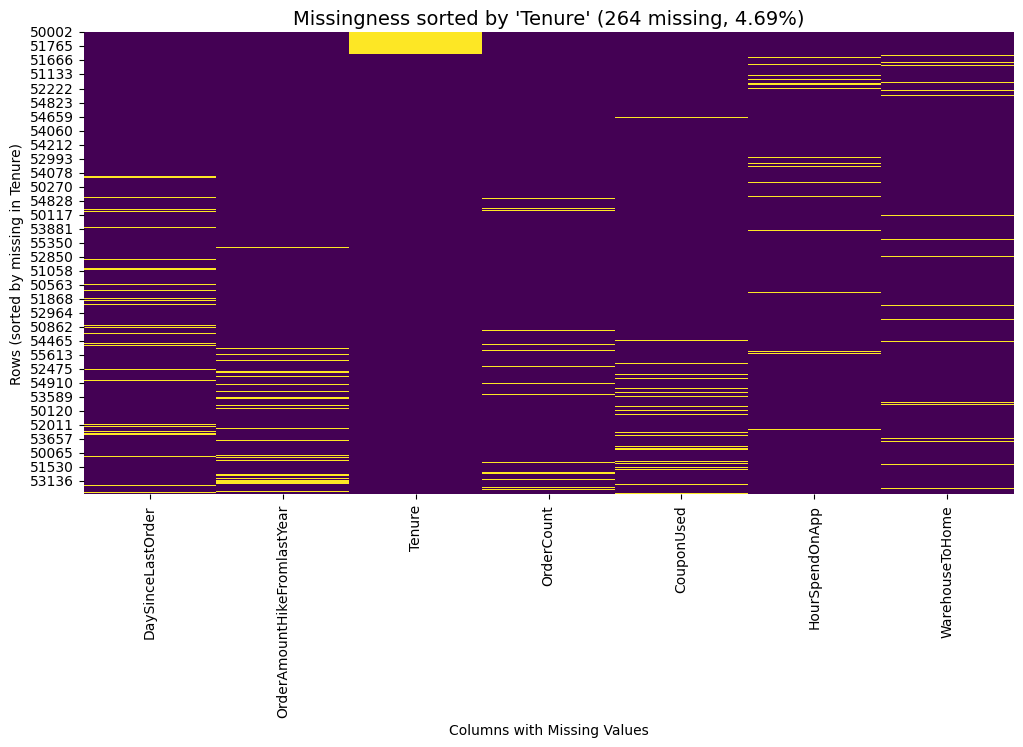

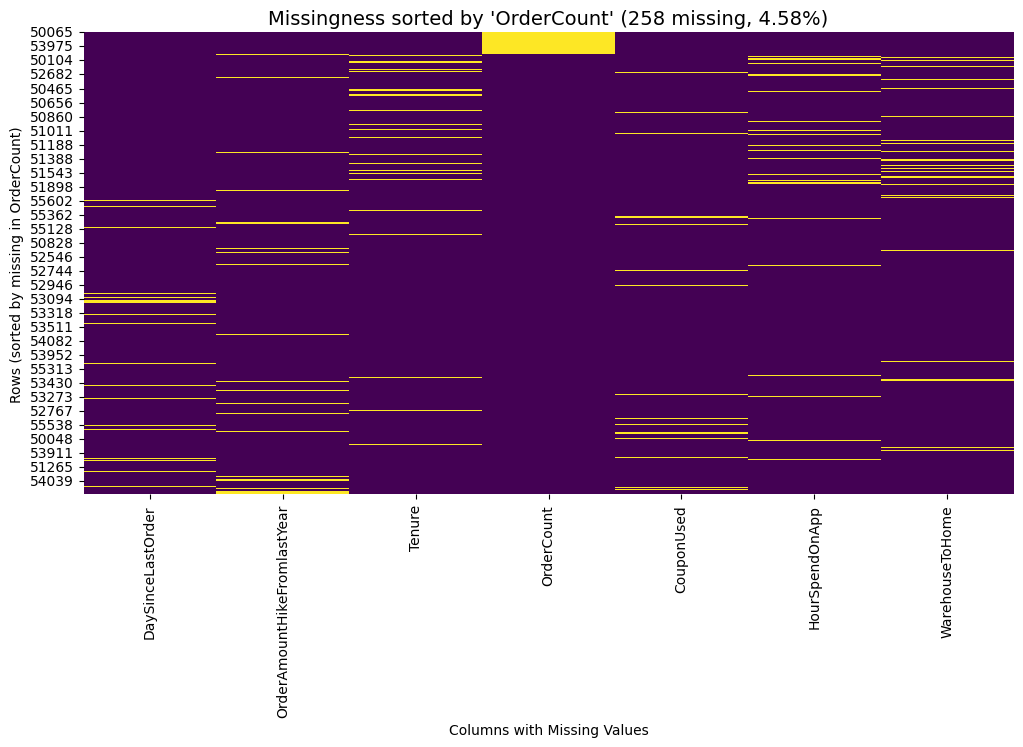

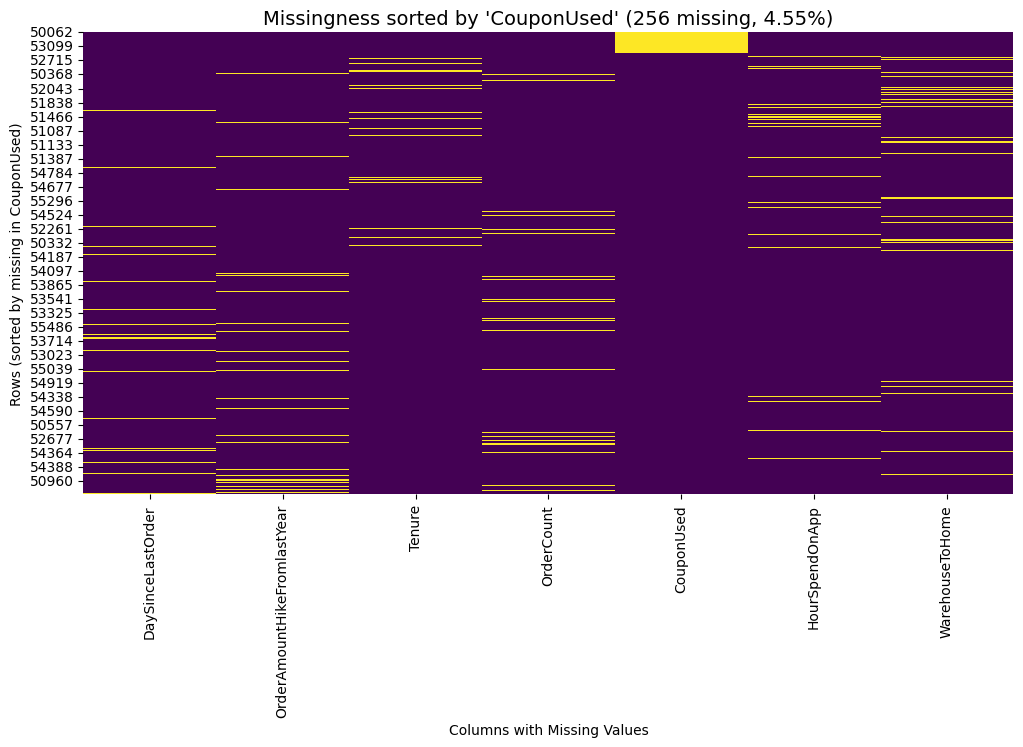

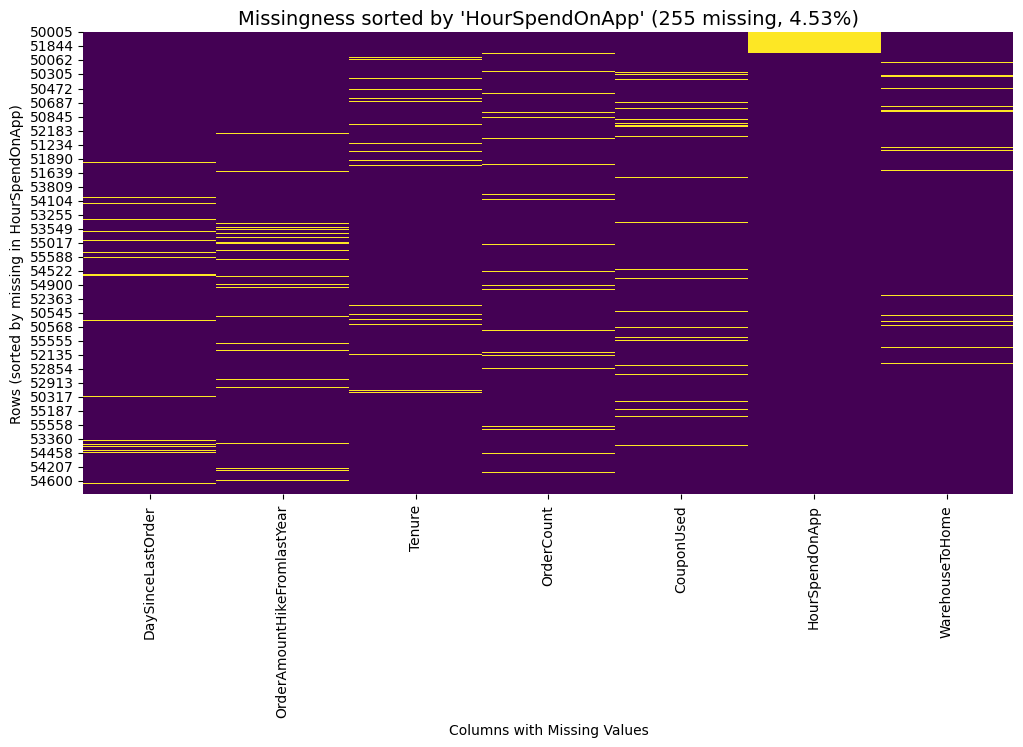

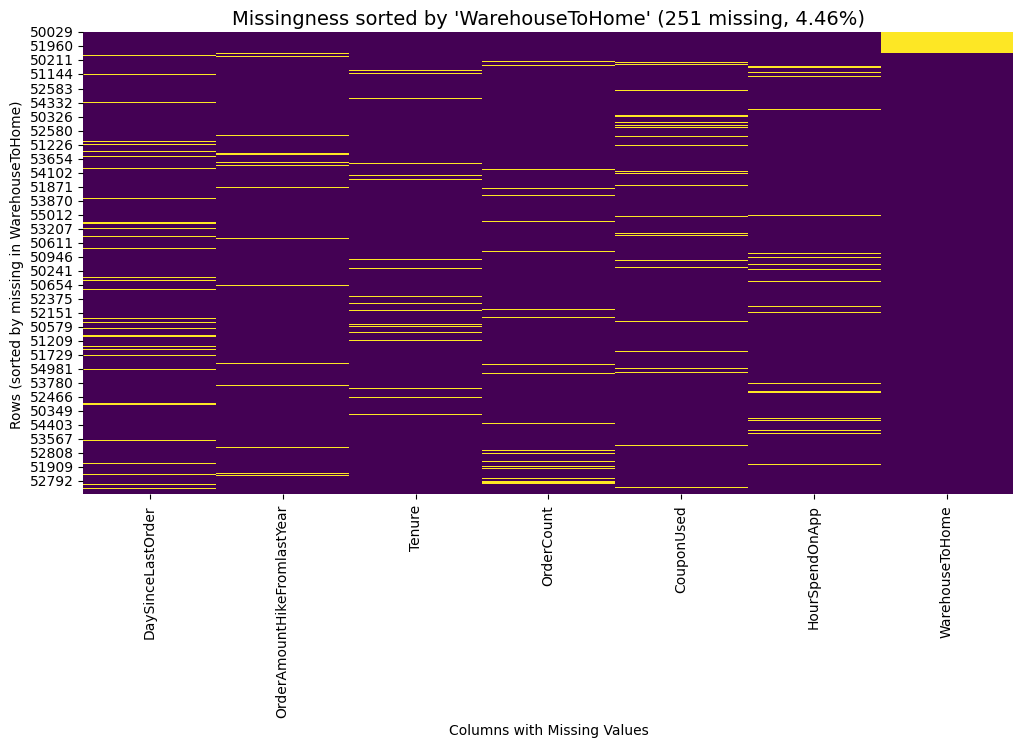

--------------------------------------------------


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Missing Values Analysis (Iterative by Feature) ---")

# Overall Missing Values
missing_data = df_ecommerce.isnull().sum()
total_rows = len(df_ecommerce)

missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage (%)': (missing_data / total_rows) * 100
}).sort_values(by='Total Missing', ascending=False)

columns_with_missing_data = missing_df[missing_df['Total Missing'] > 0]

print("\nOverall Missing values by column:")
print(columns_with_missing_data)

# --- Iterative heatmaps sorted by each missing column ---
if not columns_with_missing_data.empty:
    for col in columns_with_missing_data.index:
        # Sort rows so NaNs in `col` appear grouped together
        sorted_df = df_ecommerce.sort_values(by=col, na_position="first")

        plt.figure(figsize=(12, 6))
        sns.heatmap(
            sorted_df[columns_with_missing_data.index].isnull(),
            cbar=False, cmap="viridis"
        )
        plt.title(
            f"Missingness sorted by '{col}' "
            f"({missing_df.loc[col, 'Total Missing']} missing, "
            f"{missing_df.loc[col, 'Percentage (%)']:.2f}%)",
            fontsize=14
        )
        plt.xlabel("Columns with Missing Values")
        plt.ylabel("Rows (sorted by missing in " + col + ")")
        plt.show()

print("-" * 50)


Seems no correlation between missing values features

## 3.8. Multicollinearity and Correlation

--- Correlation Analysis (Spearman Method) ---


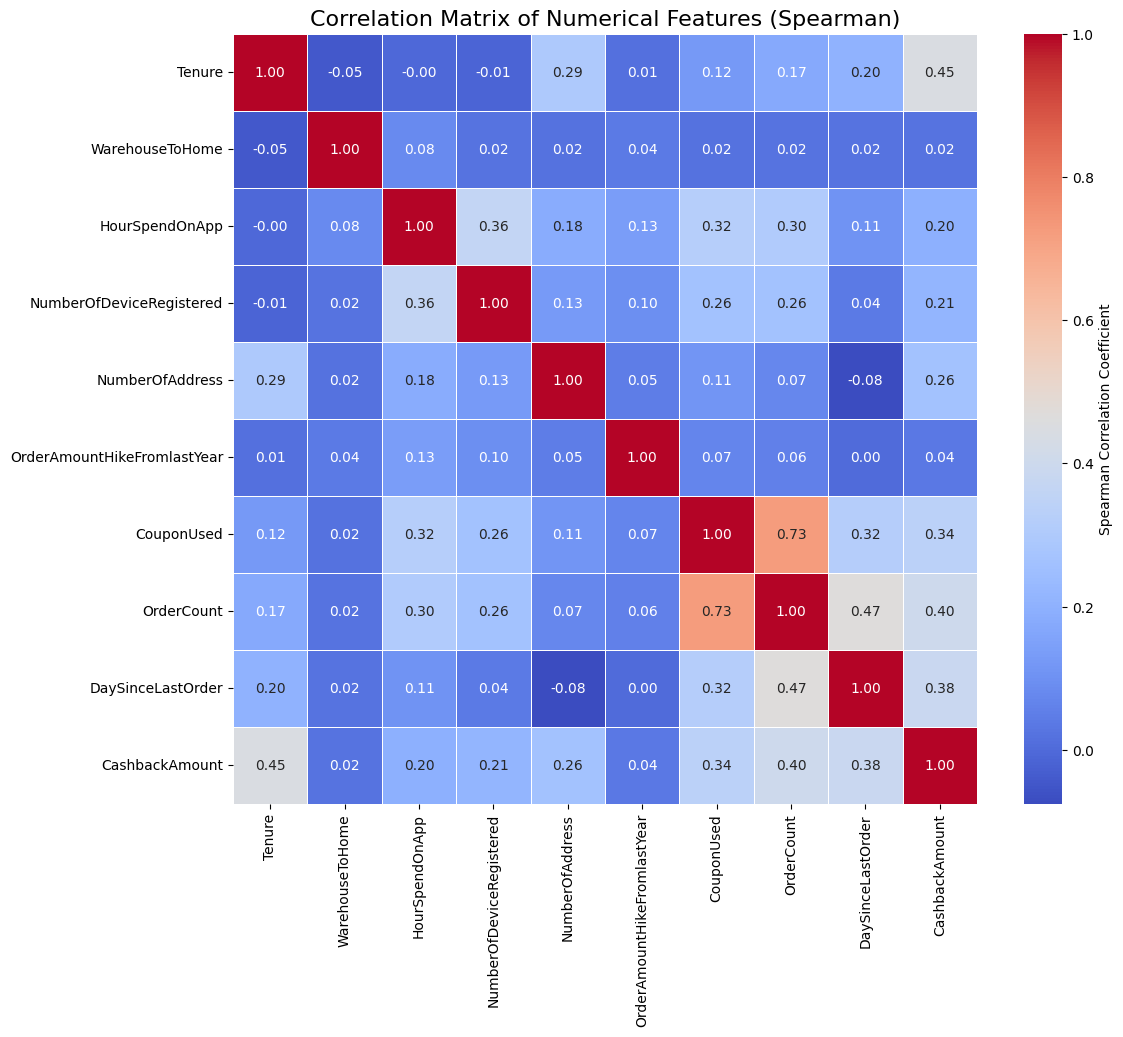

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will use only the numerical features for this analysis
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# --- Correlation Matrix and Heatmap ---
print("--- Correlation Analysis (Spearman Method) ---")

# Calculate the correlation matrix using the Spearman method
corr_matrix = df_ecommerce[numerical_features].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (Spearman)', fontsize=16)
plt.show()

### Analysis of Numerical Features and Multicollinearity

Based on the provided correlation matrix, here are the key insights.

-----

### Feature Correlations (Spearman)

The correlation matrix shows the relationships between pairs of numerical features.

  * **Moderate Positive Correlations**:
      * **OrderCount and CouponUsed (0.73)**: Customers who place more orders tend to use more coupons.
      * **DaysSinceLastOrder and OrderCount (0.47)**: This is an interesting inverse relationship. The correlation is moderate, but it suggests that as the number of orders increases, the days since the last order might also increase, or vice-versa.
      * **Tenure and CashbackAmount (0.45)**: Customers who have been with the company longer tend to receive more cashback.
  * **Weak Correlations**: Most other feature pairs show very weak correlations (values close to 0), indicating they have minimal linear relationship with each other. For example, **HoursSpendOnApp** has a very low correlation with all other features.

## 3.9. Save Dataset

In [114]:
df_ecommerce.to_csv('eda.csv')

# 4. Preprocessing

In [115]:
# --- Global variable for reproducibility ---
RANDOM_STATE = 42

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from collections import Counter
import joblib

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp',
    'NumberOfDeviceRegistered', 'NumberOfAddress',
    'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
    'DaySinceLastOrder', 'CashbackAmount'
]
categorical_features = [
    'PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice',
    'PreferredPaymentMode', 'Gender', 'Complain'
]

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 5. Build Feature Selection Pipelines ---
percentiles = [50, 60, 70, 80, 90, 100]
pipelines = {}

for p in percentiles:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('select', SelectPercentile(score_func=f_classif, percentile=p))
    ])
    pipelines[f'pipeline_fs_{p}'] = pipe

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})


In [117]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# 5. Methodology (Modeling/Analysis)

## 5.1. Benchmark Model

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    fbeta_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# --- Candidate Models ---
simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# --- Pipelines to compare (Feature Selection Percentiles) ---
percentiles = [50, 60, 70, 80, 90, 100]
pipelines = {f"FS_{p}": pipelines[f'pipeline_fs_{p}'] for p in percentiles}

# 🆕 NEW: global storage for CV summary
cv_summary = {}

# --- Benchmark Function ---
def benchmark_feature_selection_pipeline(pipeline_name, pipeline, models, X_train, y_train, X_test, y_test, cv=5):
    cv_scores_per_model = {}   # 🆕 collect CV mean & std per model

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    for name, model in models.items():
        full_pipeline = ImbPipeline(steps=pipeline.steps + [('model', model)])

        # --- Cross-validation (on train set only) ---
        f2_cv = cross_val_score(full_pipeline, X_train, y_train, cv=skf,
                                scoring=lambda est, X, y: fbeta_score(y, est.predict(X), beta=2))
        cv_mean = f2_cv.mean()
        cv_std = f2_cv.std()

        cv_scores_per_model[name] = (cv_mean, cv_std)  # 🆕 store it

        # --- Fit on full training data ---
        full_pipeline.fit(X_train, y_train)

    # 🆕 Save CV summary for global comparison
    cv_summary[pipeline_name] = cv_scores_per_model

# --- Run Benchmark for All Feature Selection Pipelines ---
for name, pipe in pipelines.items():
    benchmark_feature_selection_pipeline(
        name, pipe, simple_models, X_train, y_train, X_test, y_test, cv=5
    )

# 🆕 --- CV Mean & Std Summary Table ---
cv_table = pd.DataFrame({
    fs_name: {model: f"{mean:.4f} ± {std:.4f}" for model, (mean, std) in models_cv.items()}
    for fs_name, models_cv in cv_summary.items()
})
print("\n=== Cross-Validation Evaluation F2 Score (Mean ± Std) ===")
print(cv_table.to_string())

# 🆕 --- CV Mean Δ Change Table ---
cv_delta = pd.DataFrame({
    model: [
        cv_summary[f"FS_{p2}"][model][0] - cv_summary[f"FS_{p1}"][model][0]
        for p1, p2 in zip(percentiles[:-1], percentiles[1:])
    ]
    for model in simple_models.keys()
}, index=[f"{p1}->{p2}" for p1, p2 in zip(percentiles[:-1], percentiles[1:])])

print("\n=== Δ Mean Cross-Validation Evaluation F2 Score per Feature Selection Change ===")
print(cv_delta.to_string(float_format="%.4f"))


=== Cross-Validation Evaluation F2 Score (Mean ± Std) ===
                                  FS_50            FS_60            FS_70            FS_80            FS_90           FS_100
LogisticRegression      0.4843 ± 0.0405  0.4782 ± 0.0604  0.5374 ± 0.0350  0.5628 ± 0.0479  0.5615 ± 0.0483  0.5636 ± 0.0562
KNeighborsClassifier    0.5068 ± 0.0416  0.5269 ± 0.0424  0.5825 ± 0.0456  0.5921 ± 0.0356  0.6160 ± 0.0318  0.5617 ± 0.0227
DecisionTreeClassifier  0.7835 ± 0.0268  0.8120 ± 0.0159  0.8153 ± 0.0151  0.8229 ± 0.0153  0.8221 ± 0.0207  0.8002 ± 0.0270
RandomForestClassifier  0.7513 ± 0.0242  0.7944 ± 0.0165  0.8049 ± 0.0334  0.7972 ± 0.0328  0.8079 ± 0.0255  0.7875 ± 0.0373
XGBClassifier           0.7941 ± 0.0350  0.8162 ± 0.0289  0.8298 ± 0.0260  0.8301 ± 0.0305  0.8460 ± 0.0234  0.8276 ± 0.0408

=== Δ Mean Cross-Validation Evaluation F2 Score per Feature Selection Change ===
         LogisticRegression  KNeighborsClassifier  DecisionTreeClassifier  RandomForestClassifier  XGBClassif

Feature Selection `70` percentile is chosen for next steps since globally overall model have increased mean F2 score until this point

### 5.1.1. Benchmarking With Oversampling

Use `70` percentile for ROS and SMOTE

In [119]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

# --- 1. Build Full Pipelines ---
# Pipeline with RandomOverSampler
ros_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectPercentile(score_func=f_classif, percentile=70)),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE))
])

# Pipeline with SMOTE + SelectPercentile
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectPercentile(score_func=f_classif, percentile=70)),
    ('smote', SMOTE(random_state=RANDOM_STATE))
])

In [120]:
# --- Candidate Models ---
simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# --- Pipelines ---
pipelines = {
    "FS_70_ROS": ros_pipeline,
    "FS_70_SMOTE": smote_pipeline
}

# --- Global storage for CV results ---
cv_summary_ros_smote = {}

# --- Benchmark Function ---
def benchmark_pipeline_cv_test(pipeline_name, pipeline, models, X_train, y_train, X_test, y_test, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    cv_scores_per_model = {}
    test_scores_per_model = []

    for model_name, model in models.items():
        full_pipeline = ImbPipeline(steps=pipeline.steps + [('model', model)])

        # === Cross-validation (Train only) ===
        f2_cv = cross_val_score(
            full_pipeline, X_train, y_train, cv=skf,
            scoring=lambda est, X, y: fbeta_score(y, est.predict(X), beta=2)
        )
        cv_mean = f2_cv.mean()
        cv_std = f2_cv.std()
        cv_scores_per_model[model_name] = (cv_mean, cv_std)

        # === Fit to full training set ===
        full_pipeline.fit(X_train, y_train)

    # --- Store CV summary globally ---
    cv_summary_ros_smote[pipeline_name] = cv_scores_per_model

    return pd.DataFrame(test_scores_per_model)

# --- Run for ROS & SMOTE ---
ros_results = benchmark_pipeline_cv_test("FS_70_ROS", pipelines["FS_70_ROS"], simple_models, X_train, y_train, X_test, y_test)
smote_results = benchmark_pipeline_cv_test("FS_70_SMOTE", pipelines["FS_70_SMOTE"], simple_models, X_train, y_train, X_test, y_test)

print("\n=== Cross-Validation Evaluation F2 Score (Mean ± Std) ===")
cv_table = pd.DataFrame({
    fs_name: {model: f"{mean:.4f} ± {std:.4f}" for model, (mean, std) in models_cv.items()}
    for fs_name, models_cv in cv_summary_ros_smote.items()
})
print(cv_table.to_string())


=== Cross-Validation Evaluation F2 Score (Mean ± Std) ===
                              FS_70_ROS      FS_70_SMOTE
LogisticRegression      0.6892 ± 0.0270  0.6760 ± 0.0345
KNeighborsClassifier    0.8103 ± 0.0189  0.8168 ± 0.0091
DecisionTreeClassifier  0.7786 ± 0.0280  0.7829 ± 0.0450
RandomForestClassifier  0.8466 ± 0.0303  0.8165 ± 0.0254
XGBClassifier           0.8640 ± 0.0250  0.8280 ± 0.0338


`XGBoostClassifier` and `RandomForestClassifier` perform better using `ROS` in the same feature selection `70` percentile compare to original and `SMOTE` oversampling.

`XGBoostClassifier` and `RandomForestClassifier`, feature selection `70` percentile and `ROS` are chosen for hyperparameter tuning.

## 5.2. Hyperparameter Tuning

- Models: `XGBoostClassifier` and `RandomForestClassifier`
- Preprocess pipeline with Feature Selection `70` percentile + `ROS`


--- Running RF+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for RF+ROS: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV F2-Score: 0.8560 ± 0.0259

--- Running XGB+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for XGB+ROS: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Best CV F2-Score: 0.8660 ± 0.0254

=== Cross-Validation F2 Score Summary (Mean ± Std) ===
Experiment CV F2 (mean ± std)
   XGB+ROS    0.8660 ± 0.0254
    RF+ROS    0.8560 ± 0.0259

✅ Best experiment based on CV F2: XGB+ROS (0.8660)

--- Final Results (Train vs. Test) for Best Model ---
  Metric  XGB+ROS (Train)  XGB+ROS (Test)
F2-Score           1.0000          0.9601
 ROC-AUC           1.0000          0.9983


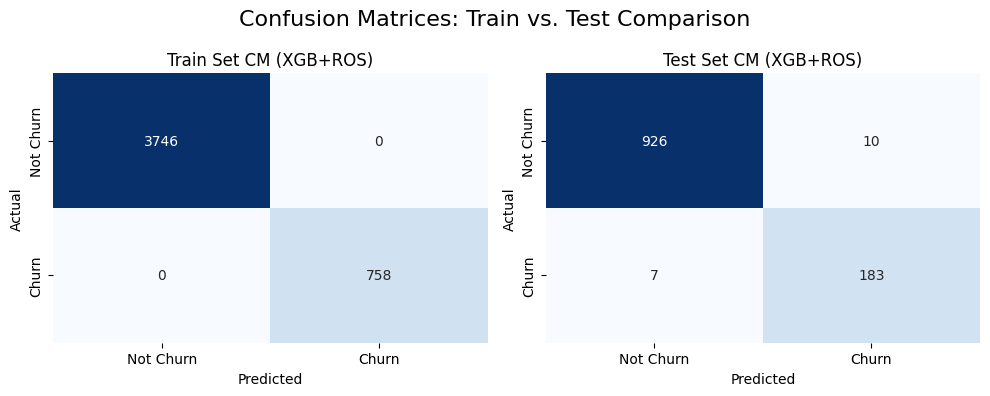

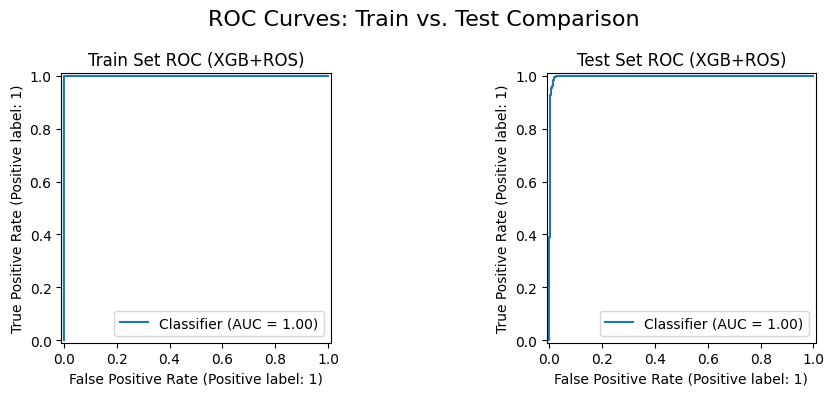

✅ Best model pipeline saved as best_model_fs_pipeline.pkl


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    fbeta_score, roc_auc_score,
    confusion_matrix, make_scorer, RocCurveDisplay
)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Hyperparameter Grids ---
rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [1, 2, 4],
}

xgb_params = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
}

# --- Experiments Setup (ROS only with FS 70) ---
experiments = {
    "RF+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "params": rf_params
    },
    "XGB+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", XGBClassifier(
                random_state=RANDOM_STATE,
                # use_label_encoder=False,
                eval_metric="logloss"
            ))
        ]),
        "params": xgb_params
    }
}

# --- Custom Scorers ---
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring_metrics = {
    "F2-Score": f2_scorer,
    "ROC-AUC": make_scorer(roc_auc_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Run Experiments ---
cv_summary = []
results = []
conf_matrices = {}
roc_curves = {}
best_model = None
best_score = 0
best_name = None
# --- NEW VARIABLES FOR TRAIN/TEST COMPARISON ---
train_metrics = {}
test_metrics = {}
best_train_preds = None
best_test_preds = None
best_train_probas = None
best_test_probas = None
# --------------------------------------------------

for name, exp in experiments.items():
    print(f"\n--- Running {name} ---")
    
    grid = GridSearchCV(
        estimator=exp["pipeline"],
        param_grid=exp["params"],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)

    # --- Best CV Score + Std ---
    best_idx = grid.best_index_
    best_mean = grid.cv_results_["mean_test_score"][best_idx]
    best_std = grid.cv_results_["std_test_score"][best_idx]
    cv_summary.append({"Experiment": name, "CV F2 (mean)": best_mean, "CV F2 (std)": best_std})
    
    best_estimator = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV F2-Score: {best_mean:.4f} ± {best_std:.4f}")
    
    if best_mean > best_score:
        # --- Test Predictions ---
        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = (
            best_estimator.predict_proba(X_test)[:, 1]
            if hasattr(best_estimator, "predict_proba") else None
        )
        
        # --- Train Predictions (for the whole train set) ---
        y_pred_train = best_estimator.predict(X_train)
        y_pred_proba_train = (
            best_estimator.predict_proba(X_train)[:, 1]
            if hasattr(best_estimator, "predict_proba") else None
        )
        
        # Calculate Test Metrics
        f2_test = fbeta_score(y_test, y_pred_test, beta=2)
        roc_auc_test = roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else None

        # Calculate Train Metrics
        f2_train = fbeta_score(y_train, y_pred_train, beta=2)
        roc_auc_train = roc_auc_score(y_train, y_pred_proba_train) if y_pred_proba_train is not None else None

        # Store Test Metrics for Summary Table
        test_metrics = {
            "Experiment": name,
            "F2-Score (Test)": f2_test,
            "ROC-AUC (Test)": roc_auc_test
        }
        
        # Store Train Metrics for Summary Table
        train_metrics = {
            "Experiment": name,
            "F2-Score (Train)": f2_train,
            "ROC-AUC (Train)": roc_auc_train
        }

        # Store CM and ROC data for the overall best model (Train and Test)
        best_train_preds = (y_train, y_pred_train)
        best_test_preds = (y_test, y_pred_test)
        
        if y_pred_proba_train is not None:
             best_train_probas = (y_train, y_pred_proba_train)
        if y_pred_proba_test is not None:
             best_test_probas = (y_test, y_pred_proba_test)
        
        best_score = best_mean
        best_model = best_estimator
        best_name = name

# --- 📊 CV Summary Table ---
cv_df = pd.DataFrame(cv_summary).sort_values(by="CV F2 (mean)", ascending=False)
print("\n=== Cross-Validation F2 Score Summary (Mean ± Std) ===")
cv_df["CV F2 (mean ± std)"] = cv_df.apply(lambda r: f"{r['CV F2 (mean)']:.4f} ± {r['CV F2 (std)']:.4f}", axis=1)
print(cv_df[["Experiment", "CV F2 (mean ± std)"]].to_string(index=False))

print(f"\n✅ Best experiment based on CV F2: {best_name} ({best_score:.4f})")

# --- Results Summary (Combined Train and Test Metrics for Best Model) ---
if best_name:
    results_combined = {
        "Metric": ["F2-Score", "ROC-AUC"],
        f"{best_name} (Train)": [
            train_metrics["F2-Score (Train)"], train_metrics["ROC-AUC (Train)"]
        ],
        f"{best_name} (Test)": [
            test_metrics["F2-Score (Test)"], test_metrics["ROC-AUC (Test)"]
        ]
    }
    results_df = pd.DataFrame(results_combined)
    print("\n--- Final Results (Train vs. Test) for Best Model ---")
    print(results_df.to_string(index=False, float_format="%.4f"))


# --- Plot Confusion Matrices (Train vs. Test for Best Model) ---
if best_train_preds and best_test_preds:
    cm_train = confusion_matrix(*best_train_preds)
    cm_test = confusion_matrix(*best_test_preds)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Train CM
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0],
                xticklabels=["Not Churn", "Churn"],
                yticklabels=["Not Churn", "Churn"])
    axes[0].set_title(f"Train Set CM ({best_name})")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # Test CM
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1],
                xticklabels=["Not Churn", "Churn"],
                yticklabels=["Not Churn", "Churn"])
    axes[1].set_title(f"Test Set CM ({best_name})")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    
    fig.suptitle("Confusion Matrices: Train vs. Test Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Plot ROC Curves (Train vs. Test for Best Model) ---
if best_train_probas and best_test_probas:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Train ROC
    RocCurveDisplay.from_predictions(best_train_probas[0], best_train_probas[1], ax=axes[0])
    axes[0].set_title(f"Train Set ROC ({best_name})")

    # Test ROC
    RocCurveDisplay.from_predictions(best_test_probas[0], best_test_probas[1], ax=axes[1])
    axes[1].set_title(f"Test Set ROC ({best_name})")

    fig.suptitle("ROC Curves: Train vs. Test Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Save Best Model Pipeline ---
joblib.dump(best_model, "best_model_fs_pipeline.pkl")
print("✅ Best model pipeline saved as best_model_fs_pipeline.pkl")

Best Model: `XGBClassifier` with `70` percentile feature selection and `Random Oversampling`
Best Params: `{'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}`

This model performs very good with mean evaluation F2 score `0.866` and standard deviation `0.0254`. No overfit clearly shown by F2 score `1.0` train and `0.96` test, ROC AUC score `1.0` train and `0.998` test.

## 5.3. Feature Importances

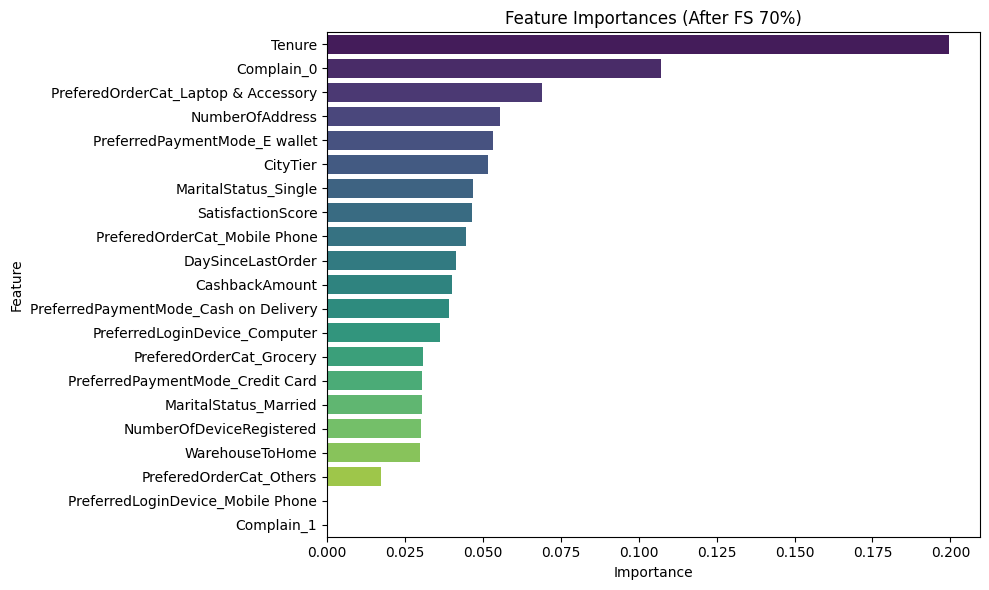


Top 10 features by importance:
                            Feature  Importance
                             Tenure    0.199539
                         Complain_0    0.107013
PreferedOrderCat_Laptop & Accessory    0.069124
                    NumberOfAddress    0.055610
      PreferredPaymentMode_E wallet    0.053189
                           CityTier    0.051499
               MaritalStatus_Single    0.046773
                  SatisfactionScore    0.046418
      PreferedOrderCat_Mobile Phone    0.044706
                  DaySinceLastOrder    0.041498


In [122]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load best pipeline ---
best_pipeline = joblib.load("best_model_fs_pipeline.pkl")

# --- Locate preprocessor & selector ---
preprocessor = None
selector = None
for name, step in best_pipeline.named_steps.items():
    if hasattr(step, "transformers_"):  # ColumnTransformer
        preprocessor = step
    if hasattr(step, "get_support"):    # Feature Selector (e.g., SelectPercentile)
        selector = step

if preprocessor is None:
    raise ValueError("Could not find a ColumnTransformer in the pipeline.")
if selector is None:
    raise ValueError("Could not find a Feature Selector in the pipeline.")

# --- Get all feature names after preprocessing ---
all_features = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        all_features.extend(trans.get_feature_names_out(cols))
    else:
        all_features.extend(cols)

# --- Apply selector support mask to keep only selected features ---
selected_features = [f for f, keep in zip(all_features, selector.get_support()) if keep]

# --- Get final model ---
model = best_pipeline.named_steps["model"]

# --- Get feature importances ---
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    raise ValueError("The model does not support feature importances.")

# --- Create DataFrame ---
feat_imp = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances (After FS 70%)")
plt.tight_layout()
plt.show()

# --- Print top 10 ---
print("\nTop 10 features by importance:")
print(feat_imp.head(10).to_string(index=False))


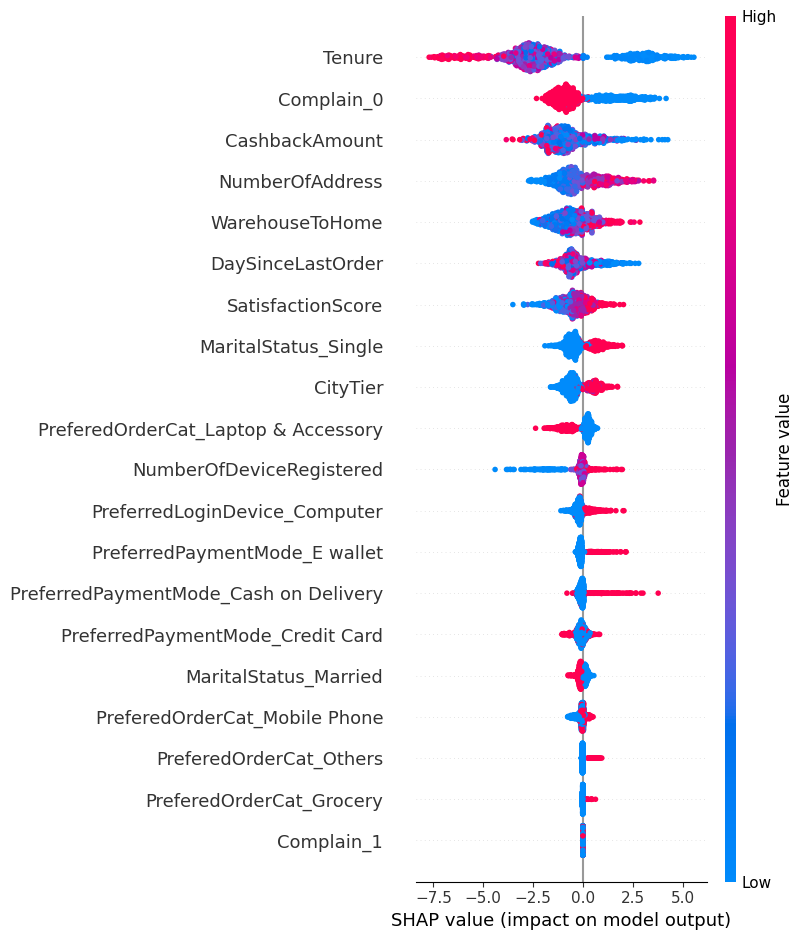

Predicted class: 0
Actual class: 0


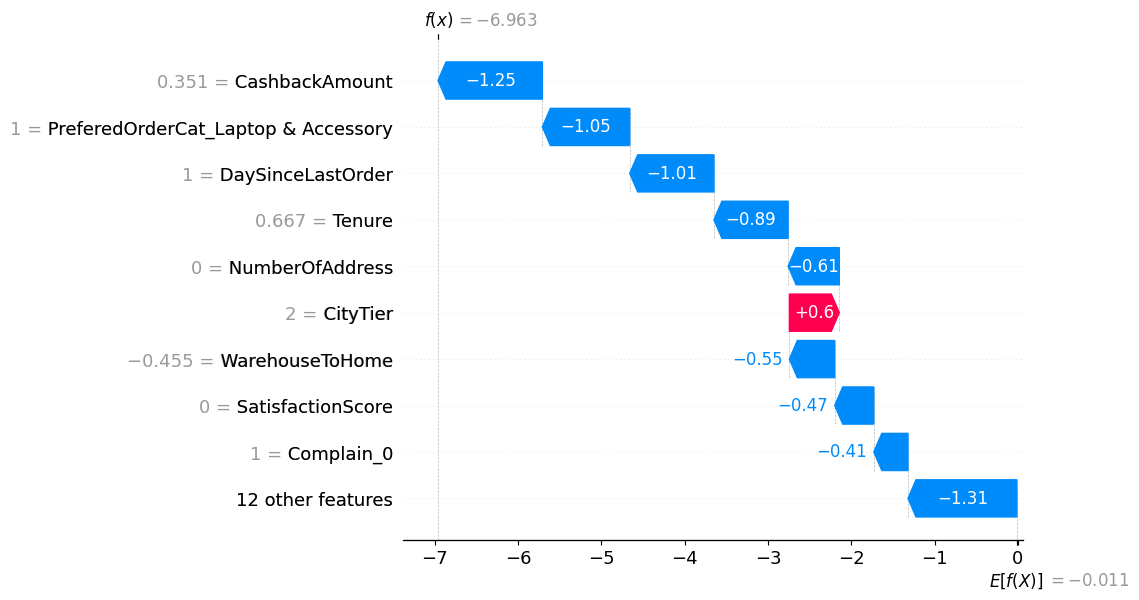

In [123]:
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load the best pipeline ---
best_pipeline = joblib.load("best_model_fs_pipeline.pkl")

# --- Extract steps ---
preprocessor = best_pipeline.named_steps["preprocessor"]
selector = best_pipeline.named_steps.get("select", None)  # feature selector may exist
model = best_pipeline.named_steps["model"]

# --- Get feature names after preprocessing ---
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# --- Transform X_test through preprocessor (and selector if present) ---
X_pre = preprocessor.transform(X_test)

if selector is not None:
    X_test_transformed = selector.transform(X_pre)
    mask = selector.get_support()
    selected_features = [f for f, keep in zip(feature_names, mask) if keep]
else:
    X_test_transformed = X_pre
    selected_features = feature_names

# Convert to DataFrame (helps shap & plotting)
X_test_df = pd.DataFrame(X_test_transformed, columns=selected_features, index=X_test.index)

# --- SHAP explainer ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# Handle binary vs multiclass
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]  # class 1 = churn
    base_value = explainer.expected_value[1]
else:
    shap_values_to_use = shap_values
    base_value = explainer.expected_value

# --- 1. Beeswarm plot (global importance) ---
shap.summary_plot(shap_values_to_use, X_test_df, feature_names=selected_features, show=True)

# --- 2. Local explanation for one sample ---
idx = 0
print("Predicted class:", best_pipeline.predict(X_test.iloc[[idx]])[0])
print("Actual class:", y_test.iloc[idx])

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_to_use[idx],
        base_values=base_value,
        data=X_test_df.iloc[idx],
        feature_names=selected_features
    )
)


* **Top Predictors of Churn:**
    * **Tenure:** This is the **single most important feature** in predicting churn. Customers with **low tenure** (pink dots on the positive side of the `Tenure` row) have a much higher likelihood of churning, while those with **high tenure** (blue dots on the negative side) are very likely to stay.
    * **Complain:** Customers who have made a complaint (`Complain_0` is false, i.e., they complained) have a very high positive SHAP value, indicating they are **highly likely to churn**.
    * **Number of Addresses:** A **lower number of addresses** (pink dots) is associated with an increased likelihood of churn.
* **Other Key Insights:**
    * **Cashback Amount:** Customers with **low cashback amounts** (pink dots) are more prone to churning.
    * **Day Since Last Order & Warehouse to Home:** Longer periods since the last order and greater distance from the warehouse to home (pink dots) both contribute to a higher churn risk.
    * **Satisfaction Score:** A **higher satisfaction score** (pink dots) is clearly correlated with a higher probability of churning. (Satisfaction scores maybe measured not from purchase reviews, but from app reviews or customer service feedback.)
    * **Order Count:** While it was a positive factor for the single customer in the waterfall plot, the beeswarm plot shows a more complex relationship. Higher order counts (pink dots on the right) seem to slightly increase churn risk, while lower counts (blue dots) decrease it. This is an interesting finding that may require further investigation, as it could indicate that a high frequency of small orders is a sign of a less engaged customer.

# 6. Conclusion & Recommendations

## 6.1. 📈 Conclusions

A high-performing **XGBoost** model is successfully developed to predict customer churn.  
Using a **SelectPercentile feature selection (70%)**, the number of features was reduced from **31 to 21** while maintaining strong model performance.  

The primary metric, **F2-Score**, which prioritizes recall (catching churners), remains excellent, with the feature-selected model achieving a score of **0.960**.  

✅ This demonstrates that the model is highly effective at identifying customers at risk of churning while operating with a more compact feature set.

***

* **Tenure:** This is the **most significant predictor** of churn. New customers (`low Tenure`) are far more likely to churn than long-term customers. This is a common pattern and suggests that the initial customer experience is critical.
* **Customer Complaints:** Having a complaint on file (`Complain_0`) is the **second most important factor** and a very strong indicator of churn risk. Customers who have complained are highly likely to leave.
* **Marital Status:** Being single (`MaritalStatus_Single`) is a notable predictor of churn, while being married has a smaller impact. This finding aligns with the observation that different customer demographics have different churn probabilities.
* **Order and Engagement Metrics:** Customers who receive bigger CashbackAmount are less likely to churn, while customers who show have more addresses and far distance are more likely to churn. The SatisfactionScore may not have clear measure in what context it is since the higher score seems more likely to churn (Satisfaction scores maybe measured not from purchase reviews, but from app reviews or customer service feedback).

## 6.2. Recommendations & Actionable Insights ✅

* **Engage New Customers Early**
    * **Stakeholders:** Marketing Team, Product Manager
    * **Duration:** **90 days**
    * **Action:** Marketing crafts personalized content/offers; Product Manager manages in-app onboarding features.

* **Prioritize Complaint Resolution**
    * **Stakeholders:** Customer Support, Data Analytics Teams
    * **Duration:** **1-2 months**
    * **Action:** Customer Support implements a fast-track resolution system; Data Analytics monitors post-resolution satisfaction.

* **Boost Engagement for At-Risk Segments**
    * **Stakeholders:** Marketing Team, Data Analytics, Product Manager
    * **Duration:** **2-3 months**
    * **Action:** Data identifies dissatisfied/low-cashback users; Marketing designs loyalty campaigns; Product Manager prepares campaign features.

* **Develop Demographic-Specific Campaigns**
    * **Stakeholders:** Marketing, Data Analytics Teams
    * **Duration:** **2 months**
    * **Action:** Data designs demographic segmentation; Marketing creates and executes tailored campaigns (e.g., for single customers).

## ⚡ 6.3. Measurable Business Impact

![](./assets/final_fs_confusion_matrix.png)

### Assumptions for this Simulation 💰

We’ll calculate costs using the general formula:  

**Total Cost = (FP + TP) × CRC + FN × CAC**

* **Customer Retention Cost (CRC):** $17  
* **Customer Acquisition Cost (CAC):** $85 [Reference](https://www.upcounting.com/blog/average-ecommerce-customer-acquisition-cost?utm_source=chatgpt.com)   
* **Sample Size:** 1,126 customers  

---

### 1. Cost With Model (Best Pipeline Confusion Matrix)

- **TP = 183**  
- **FP = 10**  
- **FN = 7**  

**Calculation:**  
- (TP + FP) × CRC = (183 + 10) × 50 = 193 × 17 = **$3,281**  
- FN × CAC = 7 × 85 = **$595**  
- **Total Cost (With Model) = $3,281 + $595 = $3,876**  

---

### 2. Cost Without Model (Naive: Treat All as At-Risk)

- **TP = 190** (all churners)  
- **FP = 936** (all non-churners treated as at-risk)  
- **FN = 0**  

**Calculation:**  
- (TP + FP) × CRC = (190 + 936) × 17 = 1,126 × 17 = **$19,142**  
- FN × CAC = 0 × 85 = **$0**  
- **Total Cost (Without Model) = $19,142**  

---

### 3. Cost Comparison  

| Scenario         | Formula Applied                       | Total Cost |
|------------------|---------------------------------------|------------|
| **With Model**   | (TP + FP) × CRC + FN × CAC = 193×17 + 7×85 | **$3,876** |
| **Without Model**| (TP + FP) × CRC + FN × CAC = 1,126×17 + 0   | **$19,142** |
| **Savings**      | —                                     | **$15,266** |

---

✅ By deploying this model, the business reduces costs from **$19,142** down to **$3,876**, achieving a net saving of **$15,266** — which is roughly **79.7% lower cost** compared to the naive approach.